In [117]:
import seaborn as sns
import pandas as pd
import pylab as plt
import numpy as np
from steam import WebAPI
from datetime import datetime
import os
import glob
import json
import tensorflow as tf
import sys
from IPython import display
import requests
import tensorflow.keras.backend as K
from sklearn import decomposition

#import logging
#logging.getLogger("tensorflow").setLevel(logging.ERROR)

#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

#dont keep api key in github!!!
api_file = os.path.join('..','..','..','apikeys','steam_api_key.txt')
with open(api_file, 'r') as fin:
    api = WebAPI(key=fin.readline())

print(tf.__version__)

2.0.0


In [21]:
sns.set_style('ticks')

In [9]:
#declare interface urls
#dota2_beta should be used for testing in order to not aggressively make API requests
dota2_id = '570'
dota2_beta_id = '205790'

hero_list = api.call('IEconDOTA2_'+dota2_id+'.GetHeroes')
hero_vocab=[int(hero_id['id']) for hero_id in hero_list['result']['heroes']] 
print(len(hero_vocab))

117


# Modeling using a TFRecord dataformat

## Build TFRecord input pipeline

In [10]:
def _parse_function(example_proto):
    """Extracts features and labels.
  
    Args:
        example_proto: tf.Example protocol (unsure what this is)    
      Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
    """
    features = {
        "radiant_heroes": tf.io.FixedLenFeature(5, tf.int64), #array of five 8 bit ints for heroes
        "dire_heroes": tf.io.FixedLenFeature(5, tf.int64), #array of five 8-bit ints for heroes
        "label": tf.io.FixedLenFeature(1, tf.int64)
                }
    parsed_features = tf.io.parse_single_example(example_proto, features)
    
    radiant_heroes = parsed_features['radiant_heroes']
    dire_heroes = parsed_features['dire_heroes']
    
    labels = parsed_features['label']
    
    #return radiant_heroes,dire_heroes, labels
    return {'radiant_heroes':radiant_heroes,'dire_heroes': dire_heroes}, labels

In [11]:
def _parse_function_nodict(example_proto):
    """Extracts features and labels.
  
    Args:
        example_proto: tf.Example protocol (unsure what this is)    
      Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
    """
    features = {
        "radiant_heroes": tf.io.FixedLenFeature(5, tf.int64), #array of five 8 bit ints for heroes
        "dire_heroes": tf.io.FixedLenFeature(5, tf.int64), #array of five 8-bit ints for heroes
        "label": tf.io.FixedLenFeature(1, tf.int64)
                }
    parsed_features = tf.io.parse_single_example(example_proto, features)
    
    radiant_heroes = parsed_features['radiant_heroes']
    dire_heroes = parsed_features['dire_heroes']
    
    labels = parsed_features['label']
    
    return [radiant_heroes,dire_heroes], labels

In [12]:
def _parse_function_dual(example_proto):
    """Extracts features and labels.
  
    Args:
        record: File path to a TFRecord file    
      Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A dict of tensors with the corresponding labels.
    """
    features = {
        "radiant_heroes": tf.io.FixedLenFeature([5], dtype=tf.int64), #array of five 8 bit ints for heroes
        "dire_heroes": tf.io.FixedLenFeature([5], dtype=tf.int64), #array of five 8-bit ints for heroes
        "radiant_win" :tf.io.FixedLenFeature([1], dtype=tf.int64),
        "gold_diff": tf.io.FixedLenFeature([1], dtype=tf.float32)
                }
  
    parsed_features = tf.io.parse_single_example(example_proto, features)
  
    radiant_heroes = parsed_features['radiant_heroes']
    dire_heroes = parsed_features['dire_heroes']
    radiant_win = parsed_features['radiant_win']
    gold_diff = parsed_features['gold_diff']

    #return  {'radiant_heroes':radiant_heroes, 'dire_heroes':dire_heroes},\
    #       {'radiant_win':radiant_win, 'gold_diff':gold_diff}
    return [radiant_heroes,dire_heroes],\
        {'gold_diff': gold_diff, 'radiant_win':radiant_win}

In [19]:
def _parse_function_triple(example_proto):
    """Extracts features and labels.
  
    Args:
        record: File path to a TFRecord file    
      Returns:
    A `tuple` `(labels, features)`:
      features: A 2D tensors representing the heroes
      labels: A dict of tensors with the corresponding labels.
    """
    features = {
        "radiant_heroes": tf.io.FixedLenFeature([5], dtype=tf.int64), #array of five 8 bit ints for heroes
        "dire_heroes": tf.io.FixedLenFeature([5], dtype=tf.int64), #array of five 8-bit ints for heroes
        "radiant_win" :tf.io.FixedLenFeature([1], dtype=tf.int64),
        "gold_diff": tf.io.FixedLenFeature([1], dtype=tf.float32),
        "total_gold": tf.io.FixedLenFeature([1], dtype=tf.float32)
                }
  
    parsed_features = tf.io.parse_single_example(example_proto, features)
  
    radiant_heroes = parsed_features['radiant_heroes']
    dire_heroes = parsed_features['dire_heroes']
    radiant_win = parsed_features['radiant_win']
    gold_diff = parsed_features['gold_diff']
    total_gold = parsed_features['total_gold']

    #return  {'radiant_heroes':radiant_heroes, 'dire_heroes':dire_heroes},\
    #       {'radiant_win':radiant_win, 'gold_diff':gold_diff}
    return [radiant_heroes,dire_heroes],\
            {'gold_diff': gold_diff,
                 'total_gold':total_gold,
                 'radiant_win':radiant_win}

#### Check the parse function worked

In [14]:
# Create the Dataset object.
ds = tf.data.TFRecordDataset(os.path.join('Dota_data',
                                          'mixed_skill',
                                          'dota2_training_data',
                                          'dual_gold_win_novocab_dota2_training_data.tfrecords'),
                             compression_type="GZIP")
# Map features and labels with the parse function.
ds = ds.map(_parse_function_multi)

NameError: name '_parse_function_multi' is not defined

In [ ]:
ds = ds.shuffle(10000)
print(tf.data.experimental.get_single_element(ds.take(1))[1])

## Model Functions

In [17]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn_multi(input_filenames, num_epochs=None, 
              shuffle=True, batch_size=50,compression_type="",target_num=2):
   
  # Same code as above; create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames,compression_type=compression_type)
    
    if target_num==2:
        ds = ds.map(_parse_function_dual)
    elif target_num==3:
        ds = ds.map(_parse_function_triple)
    elif target_num==1:
        ds = ds.map(_parse_function_nodict)
    else:
        raise KeyError
    
    if shuffle:
        ds = ds.shuffle(10000)
    
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    #gold_ds = ds.map(_parse_function_multi_to_gold)
    #win_ds = ds.map(_parse_function_multi_to_win)
    
    # Return the dataset.
    #return gold_ds, win_ds
    return ds

In [ ]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn_single_example(input_filenames, num_epochs=None, 
              shuffle=True, batch_size=50,compression_type=""):
   
   # Same code as above; create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames,compression_type=compression_type)
    ds = ds.map(_parse_function_nodict)

    if shuffle:
        ds = ds.shuffle(10000)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    
    # Return the dataset.
    return ds

In [ ]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn(input_filenames, num_epochs=None, 
              shuffle=True, batch_size=50,compression_type=""):
   
  # Same code as above; create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames,compression_type=compression_type)
    ds = ds.map(_parse_function)

    if shuffle:
        ds = ds.shuffle(10000)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    # Return the dataset.
    return ds

## Define and train the linear model

### various iterations of linear models

In [ ]:
#define the linear model with no feature columns
def train_linear_model_no_feature_columns(optimizer, 
                                          vocab_len, 
                                          embedding_dims,
                                          batch_size,
                                          epochs,
                                          training_path,
                                          validation_path,
                                          compression_type='',
                                          temp_log_flag=True):
    '''Function to define simple keras linear model
    
    Args: 
        optimizer: A `tf.keras.optimizer` object to use for the model
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `int` specifying the number of dimensions in the embedding layer
    Returns:
        history: A `tf.keras.history` object that has loss and other metrics
    '''

    all_heroes = tf.keras.Input(shape=(2,5,),name='all_heroes')

    #Put input through an embedding layer. Can make this (sort of)equivalent
    #  to an indicator column by setting dimension to 1
    x = tf.keras.layers.Embedding(input_dim=vocab_len,
                                  output_dim=embedding_dims)(all_heroes)
    
    # Adds a pooling layer with to get average team vector:
    x = tf.keras.layers.AveragePooling2D(pool_size=(1,5))(x)
    
    # Add a linear layer to map the average of the embedded vectors of each team
    #   to a single embedded vector for each team
    x = tf.keras.layers.Dense(1, activation='linear')(x)
    
    #reshape to get rid of axes of length 1
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)

    #Adds output layer with sigmoid activation for prediction
    win_predict = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=all_heroes,
                           outputs=win_predict,name="linear_classifier")
    
    model.compile(optimizer = optimizer,
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])
    
    #get embedding weights for returning and saving
    embedding_weights = triple_model.layers[1].get_weights()[0]
    
    #get datasets from tfrecords and according to input_fn
    train_ds = _input_fn_single_example(training_path,
                                       batch_size=batch_size,
                                       compression_type=compression_type)

    validation_ds= _input_fn_single_example(validation_path,
                                   batch_size=batch_size,
                                   compression_type=compression_type)

    if temp_log_flag==True:
        logdir = os.path.join('..','..','..','tmp_log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
    else:
        logdir = os.path.join('log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
        
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    steps_per_epoch=10
    history = model.fit(train_ds, 
                        epochs = epochs,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=steps_per_epoch,
                        verbose=1,
                        validation_data=validation_ds,
                        callbacks=[tensorboard_callback]
                       )
    #save params for this training to a json in the logdir
    training_params = dict({'model_type':'single_target_linear_with_embedding',
                            'steps':steps_per_epoch*epochs,
                            'embedding_dims':embedding_dims,
                            'optimizer':optimizer._name,
                            'hyper_parameters':optimizer._hyper})
    with open(os.path.join(logdir,'training_params.json',w)) as fp:
        json.dump(training_params,fp)
    
    #save embedding in numpy format for later use
    #  no hero_vocab, but that should be ok
    np.save(os.path.join(logdir,'embedding.npy'),embedding)
    
    plt.plot(history.history['accuracy'])
    plt.xlabel('epochs (10 steps per)')
    plt.ylabel('accuracy')
    plt.show()
    return embedding, history

In [ ]:
#define the linear model with feature columns
def linear_model(optimizer, feature_columns):
    '''Function to define simple keras linear model
    
    Args: 
        optimizer: A `tf.keras.optimizer` object to use for the model
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `int` specifying the number of dimensions in the embedding layer
    Returns:
        model: A `tf.keras.Sequential` model
    '''
    feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

    model = tf.keras.Sequential([
        feature_layer,
        #Adds output layer with softmax activation for prediction
        tf.keras.layers.Dense(1,activation='sigmoid')
                                ])
    
    model.compile(optimizer = optimizer,
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
#define the linear model with feature columns and dual targets
def train_linear_model_dual(optimizer, 
                             vocab_len,
                             embedding_dims,
                             batch_size,
                             epochs,
                             aux_weight,
                             training_path,
                             validation_path,
                             compression_type='',
                             temp_log_flag=True):
    '''Function to define simple keras linear model
    
    Args: 
        optimizer: A `tf.keras.optimizer` object to use for the model
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `int` specifying the number of dimensions in the embedding layer
    Returns:
        model: A `tf.keras.Model` model
    '''
    
    all_heroes = tf.keras.Input(shape=(2,5,),name='all_heroes')

    #Put input through an embedding layer. Can make this (sort of)equivalent
    #  to an indicator column by setting dimension to 1
    x = tf.keras.layers.Embedding(input_dim=vocab_len,
                                  output_dim=embedding_dims)(all_heroes)
    
    # Adds a pooling layer with to get average team vector:
    pooled_heroes = tf.keras.layers.AveragePooling2D(pool_size=(1,5))(x)
    
    # Add a linear layer to map the average of the embedded vectors of each team
    #   to a single value for each team
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    
    #reshape to get rid of axes of length 1
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)
    #Adds output layer with softmax activation for prediction
    aux_pred = tf.keras.layers.Dense(1,activation='linear',
                                      name='aux_feature')(x)
    
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)

    win_inputs = tf.keras.layers.concatenate([x,aux_pred])
    win_pred = tf.keras.layers.Dense(1,activation='sigmoid',
                                     name='radiant_win')(win_inputs)
    dual_model = tf.keras.Model(inputs=all_heroes, outputs=[aux_pred,win_pred])
    dual_model.compile(optimizer=optimizer,
                      loss = ['mse', 'binary_crossentropy'],
                      loss_weights = [aux_weight, 1],
                      metrics = ['accuracy'])
    
    #get embedding weights for returning and saving
    embedding_weights = triple_model.layers[1].get_weights()[0]

    #train_gold_ds, train_win_ds = _input_fn_multi(training_path,
    train_ds = _input_fn_multi(training_path,
                               batch_size=batch_size,
                               compression_type=compression_type,
                               target_num=2)
    
    #val_gold_ds, val_win_ds = _input_fn_multi(validation_path,
    val_ds = _input_fn_multi(validation_path,
                             batch_size=batch_size,
                             compression_type=compression_type,
                             target_num=2)


    if temp_log_flag==True:
        logdir = os.path.join('..','..','..','tmp_log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
    else:
        logdir = os.path.join('log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))

    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    steps_per_epoch=50
    history = dual_model.fit(train_ds, 
                             epochs = epochs,
                             steps_per_epoch=steps_per_epoch,
                             validation_steps=steps_per_epoch,
                             verbose=2,
                             validation_data=val_ds,
                             callbacks=[tensorboard_callback]
                            )
    
    #save params for this training to a json in the logdir
    training_params = dict({'model_type':'dual_target_linear_with_embedding',
                            'steps':steps_per_epoch*epochs,
                            'embedding_dims':embedding_dims,
                            'optimizer':optimizer._name,
                            'hyper_parameters':optimizer._hyper})
    with open(os.path.join(logdir,'training_params.json',w)) as fp:
        json.dump(training_params,fp)
    
    #save embedding in numpy format for later use
    #  no hero_vocab, but that should be ok
    np.save(os.path.join(logdir,'embedding.npy'),embedding)
    
    fig, (ax1,ax2)= plt.subplots(1,2,sharey=False)
    ax2.plot(history.history['gold_diff_loss'])
    ax1.plot(history.history['radiant_win_loss'])
    ax2.set_xlabel('epochs (50 steps per)')
    ax1.set_xlabel('epochs (50 steps per)')
    ax1.set_ylabel('win_loss')
    ax2.set_ylabel('gold_loss')
    plt.show()
    
    plt.plot(history.history['radiant_win_accuracy'])
    plt.xlabel('epochs (50 steps per)')
    plt.ylabel('accuracy')
    plt.show()

    #return gold_history,win_history
    return history

In [139]:
#define the linear model with feature columns and three targets
def train_linear_model_triple(optimizer, 
                             vocab_len,
                             embedding_dims,
                             batch_size,
                             epochs,
                             aux_weight,
                             training_path,
                             validation_path,
                             compression_type='',
                             temp_log_flag=True):
    '''Function to define simple keras linear model
    
    Args: 
        optimizer: A `tf.keras.optimizer` object to use for the model
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `int` specifying the number of dimensions in the embedding layer
    Returns:
        model: A `tf.keras.Model` model
    '''
    
    all_heroes = tf.keras.Input(shape=(2,5,),name='all_heroes')

    #Put input through an embedding layer. Can make this (sort of)equivalent
    #  to an indicator column by setting dimension to 1
    x = tf.keras.layers.Embedding(input_dim=vocab_len,
                                  output_dim=embedding_dims)(all_heroes)
    
    # Adds a pooling layer with to get average team vector:
    pooled_heroes = tf.keras.layers.AveragePooling2D(pool_size=(1,5))(x)
    
    # Add a linear layer to map the average of the embedded vectors of each team
    #   to a single value for each team
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    
    #reshape to get rid of axes of length 1
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)
    #Adds output layer with softmax activation for prediction
    gold_diff = tf.keras.layers.Dense(1,activation='linear',
                                      name='gold_diff')(x)
    
    #do similar fit and processing layers starting for total_gold
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,),input_shape=(2,1,1,))(x)
    total_gold = tf.keras.layers.Dense(1,activation='linear',
                                        name = 'total_gold')(x)
    
    #do similar fit and processing layers starting for radiant_win,
    #  and use gold_diff and total_gold to help predict win
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)
    win_inputs = tf.keras.layers.concatenate([x,gold_diff,total_gold])
    win_pred = tf.keras.layers.Dense(1,activation='sigmoid',
                                     name='radiant_win')(win_inputs)
    
    #create and compile model with three outputs
    #  with auxiliary outputs deemphasized by aux_weight
    triple_model = tf.keras.Model(inputs=all_heroes, outputs=[gold_diff,
                                                            total_gold,
                                                            win_pred])
    triple_model.compile(optimizer=optimizer,
                      loss = ['mse','mse', 'binary_crossentropy'],
                      loss_weights = [aux_weight,aux_weight, 1/0.7],
                      metrics = ['radiant_win_accuracy'])
    
    #get embedding weights for returning and saving
    embedding_weights = triple_model.layers[1].get_weights()[0]
    
    #train_gold_ds, train_win_ds = _input_fn_multi(training_path,
    train_ds = _input_fn_multi(training_path,
                               batch_size=batch_size,
                               compression_type=compression_type,
                               target_num=3)
    
    #val_gold_ds, val_win_ds = _input_fn_multi(validation_path,
    val_ds = _input_fn_multi(validation_path,
                             batch_size=batch_size,
                             compression_type=compression_type,
                             target_num=3)
    
    #log training data in temp folder unless the flag is false
    if temp_log_flag:
        logdir = os.path.join('..','..','..','tmp_log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
    else:
        logdir = os.path.join('log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
        
        
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir,
                                                          write_images=True,
                                                          embeddings_freq=1)
    steps_per_epoch = 50
    history = triple_model.fit(train_ds, 
                               epochs = epochs,
                               steps_per_epoch=steps_per_epoch,
                               validation_steps=steps_per_epoch,
                               verbose=0,
                               validation_data=val_ds,
                               callbacks=[tensorboard_callback]
                               )
    
    #save params for this training to a json in the logdir
    training_params = dict({'model_type':'triple_target_linear_with_embedding',
                            'steps':steps_per_epoch*epochs,
                            'embedding_dims':embedding_dims,
                            'auxiliary_weights':aux_weights,
                            'optimizer':optimizer._name,
                            'hyper_parameters':optimizer._hyper})
    with open(os.path.join(logdir,'training_params.json',w)) as fp:
        json.dump(training_params,fp)
    
    #save embedding in numpy format for later use
    #  no hero_vocab, but that should be ok
    np.save(os.path.join(logdir,'embedding.npy'),embedding)
        
    #plot results with loss side by side and win accuracy alone
    fig, [ax1,ax2,ax3]= plt.subplots(1,3,sharey=False)
    ax3.plot(history.history['total_gold_loss'])
    ax2.plot(history.history['gold_diff_loss'])
    ax1.plot(history.history['radiant_win_loss'])
    ax3.set_xlabel('epochs (50 steps per)')
    ax2.set_xlabel('epochs (50 steps per)')
    ax1.set_xlabel('epochs (50 steps per)')
    ax1.set_ylabel('radiant_win loss')
    ax2.set_ylabel('gold_diff loss')
    ax3.set_ylabel('total_gold loss')
    plt.tight_layout()
    plt.show()
    
    plt.plot(history.history['radiant_win_accuracy'])
    plt.xlabel('epochs (50 steps per)')
    plt.ylabel('accuracy')
    plt.show()

    #return embedding weights and history for model.fit
    return embedding_weights, history

### Train model

In [41]:
def train_model(optimizer,
                embedding_dim,
                batch_size, 
                epochs, 
                training_path, 
                validation_path, 
                compression_type=''):
    """Trains a keras model.
  
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
      
    Args:
        optimizer: A `tf.keras.optimizer` to optimize loss with
        model_type: A `string` specifying the model to use
        feature_column: An `tf.feature_column` containing input data
        epochs: A non-zero `int`, the total number of training epochs. A training epoch
          consists of a forward and backward pass using a single batch.
        batch_size: A `int` specifying the number of examples for each training step.
        feature_columns: A `set` specifying the input feature columns to use.
        training_path: A `string` specifying the path to the TFRecord training data.
        validation_path: A `string` specifying the path to the TFRecord training data.
        compression_type: A `string` specifying the type of compression used for the TFRecords
      
    Returns:
        A keras `history` object trained on the training data.
    """
    
    #make linear model
    model = linear_model(optimizer,embedding_dim,vocab_len)

    
    #get batched datasets
    training_dataset = _input_fn(training_path,
                                       batch_size=batch_size,
                                       compression_type=compression_type)
    validation_dataset = _input_fn(validation_path,
                                   batch_size=batch_size,
                                   compression_type=compression_type)
    
    logdir = os.path.join('..','..','..','tmp_log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    
    history = model.fit(training_dataset, 
                        epochs = epochs,
                        steps_per_epoch=10,
                        validation_steps=10,
                        verbose=0,
                        validation_data=validation_dataset,
                        callbacks=[tensorboard_callback]
                       )
    
    plt.plot(history.history['accuracy'])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

    return history

### train no feature column win model

In [ ]:
training_file_novocab = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_training_data',
                             'radiant_win_novocab_dota2_training_data.tfrecords')
validation_file_novocab = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_validation_data',
                             'radiant_win_novocab_dota2_validation_data.tfrecords')

Train for 10 steps, validate for 10 steps
Epoch 1/500
10/10 [==============================] - 3s 313ms/step - loss: 0.6922 - accuracy: 0.5418 - val_loss: 0.6913 - val_accuracy: 0.5492
Epoch 2/500
10/10 [==============================] - 1s 128ms/step - loss: 0.6909 - accuracy: 0.5472 - val_loss: 0.6900 - val_accuracy: 0.5474
Epoch 3/500
10/10 [==============================] - 1s 128ms/step - loss: 0.6886 - accuracy: 0.5572 - val_loss: 0.6881 - val_accuracy: 0.5524
Epoch 4/500
10/10 [==============================] - 1s 124ms/step - loss: 0.6883 - accuracy: 0.5434 - val_loss: 0.6863 - val_accuracy: 0.5562
Epoch 5/500
10/10 [==============================] - 1s 129ms/step - loss: 0.6885 - accuracy: 0.5356 - val_loss: 0.6858 - val_accuracy: 0.5532
Epoch 6/500
10/10 [==============================] - 1s 137ms/step - loss: 0.6871 - accuracy: 0.5388 - val_loss: 0.6846 - val_accuracy: 0.5506
Epoch 7/500
10/10 [==============================] - 2s 155ms/step - loss: 0.6852 - accuracy: 0.5472

Epoch 58/500
10/10 [==============================] - 1s 122ms/step - loss: 0.6685 - accuracy: 0.5926 - val_loss: 0.6679 - val_accuracy: 0.5920
Epoch 59/500
10/10 [==============================] - 1s 123ms/step - loss: 0.6699 - accuracy: 0.5846 - val_loss: 0.6647 - val_accuracy: 0.5966
Epoch 60/500
10/10 [==============================] - 1s 122ms/step - loss: 0.6677 - accuracy: 0.5894 - val_loss: 0.6658 - val_accuracy: 0.5960
Epoch 61/500
10/10 [==============================] - 1s 122ms/step - loss: 0.6653 - accuracy: 0.5986 - val_loss: 0.6654 - val_accuracy: 0.5966
Epoch 62/500
10/10 [==============================] - 1s 127ms/step - loss: 0.6708 - accuracy: 0.5912 - val_loss: 0.6662 - val_accuracy: 0.5904
Epoch 63/500
10/10 [==============================] - 1s 124ms/step - loss: 0.6679 - accuracy: 0.5880 - val_loss: 0.6613 - val_accuracy: 0.6010
Epoch 64/500
10/10 [==============================] - 1s 127ms/step - loss: 0.6635 - accuracy: 0.5980 - val_loss: 0.6667 - val_accuracy:

Epoch 115/500
10/10 [==============================] - 1s 120ms/step - loss: 0.6671 - accuracy: 0.5954 - val_loss: 0.6663 - val_accuracy: 0.5968
Epoch 116/500
10/10 [==============================] - 1s 119ms/step - loss: 0.6693 - accuracy: 0.5958 - val_loss: 0.6628 - val_accuracy: 0.5998
Epoch 117/500
10/10 [==============================] - 1s 119ms/step - loss: 0.6717 - accuracy: 0.5858 - val_loss: 0.6691 - val_accuracy: 0.5864
Epoch 118/500
10/10 [==============================] - 1s 119ms/step - loss: 0.6631 - accuracy: 0.6034 - val_loss: 0.6692 - val_accuracy: 0.5858
Epoch 119/500
10/10 [==============================] - 1s 116ms/step - loss: 0.6645 - accuracy: 0.5942 - val_loss: 0.6669 - val_accuracy: 0.5946
Epoch 120/500
10/10 [==============================] - 1s 91ms/step - loss: 0.6688 - accuracy: 0.5910 - val_loss: 0.6655 - val_accuracy: 0.5914
Epoch 121/500
10/10 [==============================] - 1s 149ms/step - loss: 0.6670 - accuracy: 0.5788 - val_loss: 0.6667 - val_acc

10/10 [==============================] - 1s 128ms/step - loss: 0.6659 - accuracy: 0.5890 - val_loss: 0.6620 - val_accuracy: 0.6006
Epoch 172/500
10/10 [==============================] - 1s 125ms/step - loss: 0.6669 - accuracy: 0.5914 - val_loss: 0.6596 - val_accuracy: 0.6116
Epoch 173/500
10/10 [==============================] - 1s 126ms/step - loss: 0.6659 - accuracy: 0.5914 - val_loss: 0.6653 - val_accuracy: 0.5950
Epoch 174/500
10/10 [==============================] - 1s 125ms/step - loss: 0.6647 - accuracy: 0.5914 - val_loss: 0.6679 - val_accuracy: 0.5908
Epoch 175/500
10/10 [==============================] - 1s 126ms/step - loss: 0.6666 - accuracy: 0.5922 - val_loss: 0.6646 - val_accuracy: 0.5940
Epoch 176/500
10/10 [==============================] - 1s 126ms/step - loss: 0.6704 - accuracy: 0.5840 - val_loss: 0.6639 - val_accuracy: 0.5974
Epoch 177/500
10/10 [==============================] - 1s 128ms/step - loss: 0.6688 - accuracy: 0.5828 - val_loss: 0.6646 - val_accuracy: 0.5912

10/10 [==============================] - 1s 132ms/step - loss: 0.6718 - accuracy: 0.5856 - val_loss: 0.6678 - val_accuracy: 0.5892
Epoch 228/500
10/10 [==============================] - 1s 127ms/step - loss: 0.6608 - accuracy: 0.6078 - val_loss: 0.6679 - val_accuracy: 0.5900
Epoch 229/500
10/10 [==============================] - 1s 136ms/step - loss: 0.6705 - accuracy: 0.5796 - val_loss: 0.6633 - val_accuracy: 0.5920
Epoch 230/500
10/10 [==============================] - 1s 135ms/step - loss: 0.6648 - accuracy: 0.5920 - val_loss: 0.6705 - val_accuracy: 0.5824
Epoch 231/500
10/10 [==============================] - 1s 133ms/step - loss: 0.6677 - accuracy: 0.5934 - val_loss: 0.6646 - val_accuracy: 0.5922
Epoch 232/500
10/10 [==============================] - 1s 138ms/step - loss: 0.6715 - accuracy: 0.5834 - val_loss: 0.6659 - val_accuracy: 0.5924
Epoch 233/500
10/10 [==============================] - 1s 132ms/step - loss: 0.6685 - accuracy: 0.5880 - val_loss: 0.6672 - val_accuracy: 0.5884

10/10 [==============================] - 2s 168ms/step - loss: 0.6716 - accuracy: 0.5813 - val_loss: 0.6667 - val_accuracy: 0.5836
Epoch 284/500
10/10 [==============================] - 1s 118ms/step - loss: 0.6670 - accuracy: 0.5920 - val_loss: 0.6686 - val_accuracy: 0.5928
Epoch 285/500
10/10 [==============================] - 1s 118ms/step - loss: 0.6720 - accuracy: 0.5836 - val_loss: 0.6681 - val_accuracy: 0.5876
Epoch 286/500
10/10 [==============================] - 1s 118ms/step - loss: 0.6689 - accuracy: 0.5910 - val_loss: 0.6667 - val_accuracy: 0.5892
Epoch 287/500
10/10 [==============================] - 1s 118ms/step - loss: 0.6675 - accuracy: 0.6016 - val_loss: 0.6675 - val_accuracy: 0.5888
Epoch 288/500
10/10 [==============================] - 1s 118ms/step - loss: 0.6667 - accuracy: 0.5884 - val_loss: 0.6683 - val_accuracy: 0.5840
Epoch 289/500
10/10 [==============================] - 1s 118ms/step - loss: 0.6712 - accuracy: 0.5890 - val_loss: 0.6678 - val_accuracy: 0.5852

10/10 [==============================] - 1s 124ms/step - loss: 0.6695 - accuracy: 0.5872 - val_loss: 0.6671 - val_accuracy: 0.5854
Epoch 340/500
10/10 [==============================] - 1s 127ms/step - loss: 0.6670 - accuracy: 0.5908 - val_loss: 0.6652 - val_accuracy: 0.5968
Epoch 341/500
10/10 [==============================] - 1s 128ms/step - loss: 0.6653 - accuracy: 0.5978 - val_loss: 0.6669 - val_accuracy: 0.5920
Epoch 342/500
10/10 [==============================] - 1s 126ms/step - loss: 0.6679 - accuracy: 0.5866 - val_loss: 0.6642 - val_accuracy: 0.5952
Epoch 343/500
10/10 [==============================] - 1s 125ms/step - loss: 0.6646 - accuracy: 0.5986 - val_loss: 0.6625 - val_accuracy: 0.6000
Epoch 344/500
10/10 [==============================] - 1s 123ms/step - loss: 0.6745 - accuracy: 0.5810 - val_loss: 0.6711 - val_accuracy: 0.5884
Epoch 345/500
10/10 [==============================] - 1s 124ms/step - loss: 0.6621 - accuracy: 0.6046 - val_loss: 0.6679 - val_accuracy: 0.5870

10/10 [==============================] - 1s 119ms/step - loss: 0.6661 - accuracy: 0.5994 - val_loss: 0.6700 - val_accuracy: 0.5822
Epoch 396/500
10/10 [==============================] - 1s 121ms/step - loss: 0.6666 - accuracy: 0.5922 - val_loss: 0.6683 - val_accuracy: 0.5902
Epoch 397/500
10/10 [==============================] - 1s 137ms/step - loss: 0.6697 - accuracy: 0.5844 - val_loss: 0.6651 - val_accuracy: 0.5996
Epoch 398/500
10/10 [==============================] - 1s 124ms/step - loss: 0.6725 - accuracy: 0.5820 - val_loss: 0.6633 - val_accuracy: 0.5988
Epoch 399/500
10/10 [==============================] - 1s 124ms/step - loss: 0.6623 - accuracy: 0.6030 - val_loss: 0.6676 - val_accuracy: 0.5912
Epoch 400/500
10/10 [==============================] - 1s 127ms/step - loss: 0.6631 - accuracy: 0.5982 - val_loss: 0.6647 - val_accuracy: 0.5934
Epoch 401/500
10/10 [==============================] - 1s 136ms/step - loss: 0.6641 - accuracy: 0.5944 - val_loss: 0.6633 - val_accuracy: 0.5976

10/10 [==============================] - 1s 127ms/step - loss: 0.6637 - accuracy: 0.6008 - val_loss: 0.6684 - val_accuracy: 0.5974
Epoch 452/500
10/10 [==============================] - 1s 127ms/step - loss: 0.6666 - accuracy: 0.5870 - val_loss: 0.6663 - val_accuracy: 0.5976
Epoch 453/500
10/10 [==============================] - 1s 127ms/step - loss: 0.6666 - accuracy: 0.5886 - val_loss: 0.6661 - val_accuracy: 0.5978
Epoch 454/500
10/10 [==============================] - 1s 127ms/step - loss: 0.6719 - accuracy: 0.5828 - val_loss: 0.6718 - val_accuracy: 0.5794
Epoch 455/500
10/10 [==============================] - 1s 139ms/step - loss: 0.6655 - accuracy: 0.5944 - val_loss: 0.6660 - val_accuracy: 0.5946
Epoch 456/500
10/10 [==============================] - 1s 136ms/step - loss: 0.6686 - accuracy: 0.5916 - val_loss: 0.6651 - val_accuracy: 0.5918
Epoch 457/500
10/10 [==============================] - 1s 131ms/step - loss: 0.6682 - accuracy: 0.5840 - val_loss: 0.6643 - val_accuracy: 0.5926

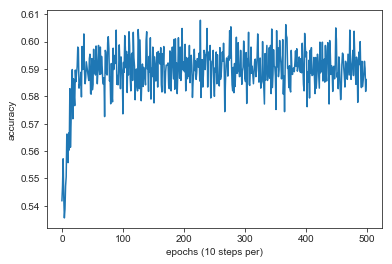

In [45]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
history = train_linear_model_no_feature_columns(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=3,
            batch_size=500, 
            epochs=500, 
            training_path=training_file_novocab, 
            validation_path=validation_file_novocab,
            compression_type='GZIP')

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
history = train_linear_model_no_feature_columns(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dim=3,
            batch_size=500, 
            epochs=50, 
            training_path=training_file_novocab, 
            validation_path=validation_file_novocab,
            compression_type='GZIP')

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
history = train_linear_model_no_feature_columns(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=3,
            batch_size=500, 
            epochs=70, 
            training_path=training_file_novocab, 
            validation_path=validation_file_novocab,
            compression_type='GZIP')

### train dual gold_diff win model

In [ ]:
training_file_dual_novocab = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_training_data',
                             'dual_gold_win_novocab_dota2_training_data.tfrecords')
validation_file_dual_novocab = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_validation_data',
                             'dual_gold_win_novocab_dota2_validation_data.tfrecords')

Train for 50 steps, validate for 50 steps
Epoch 1/20
50/50 - 6s - loss: 0.7901 - gold_diff_loss: 1.0018 - radiant_win_loss: 0.6899 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5434 - val_loss: 0.7896 - val_gold_diff_loss: 1.0064 - val_radiant_win_loss: 0.6890 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5430
Epoch 2/20
50/50 - 4s - loss: 0.7865 - gold_diff_loss: 0.9979 - radiant_win_loss: 0.6867 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5508 - val_loss: 0.7870 - val_gold_diff_loss: 1.0016 - val_radiant_win_loss: 0.6869 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5450
Epoch 3/20
50/50 - 4s - loss: 0.7849 - gold_diff_loss: 1.0023 - radiant_win_loss: 0.6846 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5491 - val_loss: 0.7858 - val_gold_diff_loss: 1.0237 - val_radiant_win_loss: 0.6834 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5478
Epoch 4/20
50/50 - 4s - loss: 0.7857 - gold_di

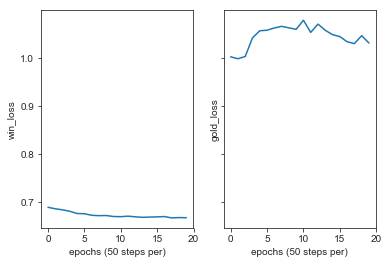

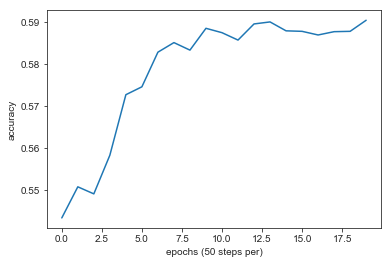

In [88]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
history = train_linear_model_dual(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=3,
            batch_size=500,
            epochs=20, 
            aux_weight=0.1,
            training_path=training_file_dual_novocab, 
            validation_path=validation_file_dual_novocab,
            compression_type='GZIP')

Train for 50 steps, validate for 50 steps
Epoch 1/40
50/50 - 8s - loss: 0.7897 - gold_diff_loss: 0.9931 - radiant_win_loss: 0.6904 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5414 - val_loss: 0.7865 - val_gold_diff_loss: 0.9884 - val_radiant_win_loss: 0.6876 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5467
Epoch 2/40
50/50 - 5s - loss: 0.7834 - gold_diff_loss: 0.9847 - radiant_win_loss: 0.6849 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5509 - val_loss: 0.7807 - val_gold_diff_loss: 0.9725 - val_radiant_win_loss: 0.6835 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5453
Epoch 3/40
50/50 - 4s - loss: 0.7764 - gold_diff_loss: 0.9729 - radiant_win_loss: 0.6791 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5629 - val_loss: 0.7715 - val_gold_diff_loss: 0.9568 - val_radiant_win_loss: 0.6758 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5737
Epoch 4/40
50/50 - 4s - loss: 0.7682 - gold_di

Epoch 28/40
50/50 - 4s - loss: 0.7633 - gold_diff_loss: 0.9434 - radiant_win_loss: 0.6689 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5859 - val_loss: 0.7636 - val_gold_diff_loss: 0.9509 - val_radiant_win_loss: 0.6685 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5908
Epoch 29/40
50/50 - 4s - loss: 0.7643 - gold_diff_loss: 0.9606 - radiant_win_loss: 0.6683 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5918 - val_loss: 0.7639 - val_gold_diff_loss: 0.9475 - val_radiant_win_loss: 0.6691 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5894
Epoch 30/40
50/50 - 4s - loss: 0.7626 - gold_diff_loss: 0.9437 - radiant_win_loss: 0.6682 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5888 - val_loss: 0.7651 - val_gold_diff_loss: 0.9515 - val_radiant_win_loss: 0.6700 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5879
Epoch 31/40
50/50 - 4s - loss: 0.7621 - gold_diff_loss: 0.9541 - radiant_win_loss: 0.

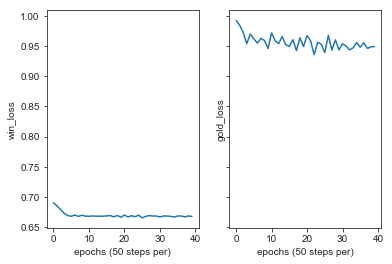

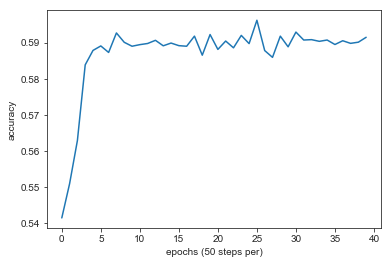

In [91]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
history = train_linear_model_dual(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=3,
            batch_size=500,
            epochs=40, 
            aux_weight=0.1,
            training_path=training_file_dual_novocab, 
            validation_path=validation_file_dual_novocab,
            compression_type='GZIP')

### train triple gold_diff, total_gold, radiant_win model

In [15]:
training_file_triple_novocab = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_training_data',
                             'triple_gold_win_novocab_dota2_training_data.tfrecords')
validation_file_triple_novocab = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_validation_data',
                             'triple_gold_win_novocab_dota2_validation_data.tfrecords')

Train for 50 steps, validate for 50 steps
Epoch 1/20
50/50 - 7s - loss: 1.1828 - gold_diff_loss: 0.9943 - total_gold_loss: 1.0005 - radiant_win_loss: 0.6883 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5419 - val_loss: 1.1796 - val_gold_diff_loss: 0.9956 - val_total_gold_loss: 1.0072 - val_radiant_win_loss: 0.6855 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5430
Epoch 2/20
50/50 - 5s - loss: 1.1733 - gold_diff_loss: 1.0030 - total_gold_loss: 0.9980 - radiant_win_loss: 0.6813 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5594 - val_loss: 1.1687 - val_gold_diff_loss: 0.9962 - val_total_gold_loss: 0.9983 - val_radiant_win_loss: 0.6785 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5685
Epoch 3/20
50/50 - 5s - loss: 1.1651 - gold_diff_loss: 1.0060 - total_gold_loss: 1.0212 - radi

Epoch 20/20
50/50 - 5s - loss: 1.1487 - gold_diff_loss: 0.9417 - total_gold_loss: 1.0142 - radiant_win_loss: 0.6672 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5907 - val_loss: 1.1527 - val_gold_diff_loss: 0.9523 - val_total_gold_loss: 1.0083 - val_radiant_win_loss: 0.6697 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5899


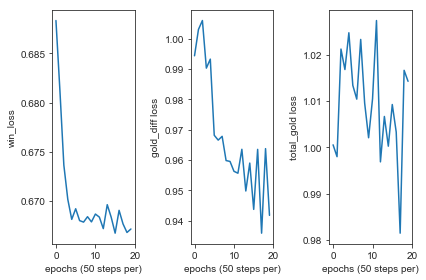

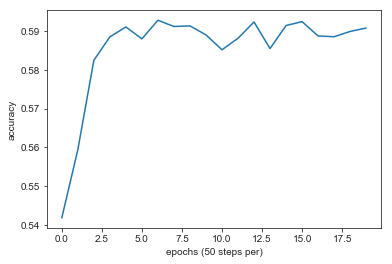

In [37]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
history = train_linear_model_triple(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=3,
            batch_size=500,
            epochs=20, 
            aux_weight=0.1,
            training_path=training_file_triple_novocab, 
            validation_path=validation_file_triple_novocab,
            compression_type='GZIP')

Train for 50 steps, validate for 50 steps
Epoch 1/200
50/50 - 8s - loss: 1.1882 - gold_diff_loss: 0.9928 - total_gold_loss: 0.9940 - radiant_win_loss: 0.6927 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5340 - val_loss: 1.1880 - val_gold_diff_loss: 0.9942 - val_total_gold_loss: 0.9962 - val_radiant_win_loss: 0.6923 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5420
Epoch 2/200
50/50 - 5s - loss: 1.1872 - gold_diff_loss: 1.0052 - total_gold_loss: 0.9851 - radiant_win_loss: 0.6917 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5510 - val_loss: 1.1878 - val_gold_diff_loss: 1.0012 - val_total_gold_loss: 0.9984 - val_radiant_win_loss: 0.6915 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5446
Epoch 3/200
50/50 - 5s - loss: 1.1895 - gold_diff_loss: 1.0028 - total_gold_loss: 1.0188 - r

Epoch 20/200
50/50 - 4s - loss: 1.1824 - gold_diff_loss: 0.9980 - total_gold_loss: 1.0030 - radiant_win_loss: 0.6876 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5474 - val_loss: 1.1825 - val_gold_diff_loss: 1.0000 - val_total_gold_loss: 0.9972 - val_radiant_win_loss: 0.6880 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5444
Epoch 21/200
50/50 - 5s - loss: 1.1830 - gold_diff_loss: 1.0102 - total_gold_loss: 1.0043 - radiant_win_loss: 0.6871 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5493 - val_loss: 1.1827 - val_gold_diff_loss: 0.9990 - val_total_gold_loss: 1.0023 - val_radiant_win_loss: 0.6878 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5450
Epoch 22/200
50/50 - 4s - loss: 1.1818 - gold_diff_loss: 0.9949 - total_gold_loss: 1.0090 - radiant_win_loss: 0.6870 - gold_diff_acc

Epoch 39/200
50/50 - 4s - loss: 1.1790 - gold_diff_loss: 0.9917 - total_gold_loss: 1.0152 - radiant_win_loss: 0.6848 - gold_diff_accuracy: 4.0000e-05 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5434 - val_loss: 1.1776 - val_gold_diff_loss: 0.9947 - val_total_gold_loss: 1.0032 - val_radiant_win_loss: 0.6845 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5453
Epoch 40/200
50/50 - 4s - loss: 1.1758 - gold_diff_loss: 0.9906 - total_gold_loss: 0.9955 - radiant_win_loss: 0.6841 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5456 - val_loss: 1.1772 - val_gold_diff_loss: 0.9998 - val_total_gold_loss: 0.9969 - val_radiant_win_loss: 0.6842 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5456
Epoch 41/200
50/50 - 5s - loss: 1.1772 - gold_diff_loss: 0.9988 - total_gold_loss: 1.0049 - radiant_win_loss: 0.6838 - gold_diff_acc

Epoch 58/200
50/50 - 5s - loss: 1.1680 - gold_diff_loss: 0.9826 - total_gold_loss: 1.0077 - radiant_win_loss: 0.6783 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5672 - val_loss: 1.1689 - val_gold_diff_loss: 0.9886 - val_total_gold_loss: 1.0051 - val_radiant_win_loss: 0.6787 - val_gold_diff_accuracy: 0.0000e+00 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5655
Epoch 59/200
50/50 - 4s - loss: 1.1673 - gold_diff_loss: 0.9922 - total_gold_loss: 0.9999 - radiant_win_loss: 0.6777 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5701 - val_loss: 1.1685 - val_gold_diff_loss: 0.9879 - val_total_gold_loss: 1.0123 - val_radiant_win_loss: 0.6779 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5668
Epoch 60/200
50/50 - 5s - loss: 1.1707 - gold_diff_loss: 0.9966 - total_gold_loss: 1.0206 - radiant_win_loss: 0.6783 - gold_diff_acc

Epoch 77/200
50/50 - 5s - loss: 1.1628 - gold_diff_loss: 0.9967 - total_gold_loss: 1.0350 - radiant_win_loss: 0.6718 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5858 - val_loss: 1.1614 - val_gold_diff_loss: 0.9764 - val_total_gold_loss: 1.0282 - val_radiant_win_loss: 0.6727 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5839
Epoch 78/200
50/50 - 4s - loss: 1.1605 - gold_diff_loss: 0.9834 - total_gold_loss: 1.0191 - radiant_win_loss: 0.6722 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5842 - val_loss: 1.1625 - val_gold_diff_loss: 0.9793 - val_total_gold_loss: 1.0307 - val_radiant_win_loss: 0.6731 - val_gold_diff_accuracy: 0.0000e+00 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5821
Epoch 79/200
50/50 - 5s - loss: 1.1615 - gold_diff_loss: 0.9840 - total_gold_loss: 1.0301 - radiant_win_loss: 0.6721 - gold_diff_acc

Epoch 96/200
50/50 - 5s - loss: 1.1597 - gold_diff_loss: 0.9787 - total_gold_loss: 1.0397 - radiant_win_loss: 0.6705 - gold_diff_accuracy: 4.0000e-05 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5868 - val_loss: 1.1602 - val_gold_diff_loss: 0.9819 - val_total_gold_loss: 1.0333 - val_radiant_win_loss: 0.6711 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5835
Epoch 97/200
50/50 - 5s - loss: 1.1581 - gold_diff_loss: 0.9815 - total_gold_loss: 1.0479 - radiant_win_loss: 0.6686 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5909 - val_loss: 1.1606 - val_gold_diff_loss: 0.9756 - val_total_gold_loss: 1.0501 - val_radiant_win_loss: 0.6706 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5849
Epoch 98/200
50/50 - 4s - loss: 1.1583 - gold_diff_loss: 0.9721 - total_gold_loss: 1.0275 - radiant_win_loss: 0.6708 - gold_diff_acc

Epoch 115/200
50/50 - 5s - loss: 1.1571 - gold_diff_loss: 0.9727 - total_gold_loss: 1.0421 - radiant_win_loss: 0.6690 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5870 - val_loss: 1.1592 - val_gold_diff_loss: 0.9747 - val_total_gold_loss: 1.0546 - val_radiant_win_loss: 0.6694 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5882
Epoch 116/200
50/50 - 4s - loss: 1.1575 - gold_diff_loss: 0.9879 - total_gold_loss: 1.0364 - radiant_win_loss: 0.6686 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5898 - val_loss: 1.1591 - val_gold_diff_loss: 0.9725 - val_total_gold_loss: 1.0523 - val_radiant_win_loss: 0.6697 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5898
Epoch 117/200
50/50 - 5s - loss: 1.1577 - gold_diff_loss: 0.9763 - total_gold_loss: 1.0628 - radiant_win_loss: 0.6677 - gold_diff_

Epoch 134/200
50/50 - 4s - loss: 1.1549 - gold_diff_loss: 0.9737 - total_gold_loss: 1.0342 - radiant_win_loss: 0.6679 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5915 - val_loss: 1.1564 - val_gold_diff_loss: 0.9687 - val_total_gold_loss: 1.0418 - val_radiant_win_loss: 0.6688 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5891
Epoch 135/200
50/50 - 5s - loss: 1.1543 - gold_diff_loss: 0.9722 - total_gold_loss: 1.0423 - radiant_win_loss: 0.6670 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5928 - val_loss: 1.1583 - val_gold_diff_loss: 0.9685 - val_total_gold_loss: 1.0470 - val_radiant_win_loss: 0.6697 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5856
Epoch 136/200
50/50 - 4s - loss: 1.1598 - gold_diff_loss: 0.9765 - total_gold_loss: 1.0540 - radiant_win_loss: 0.6697 - gold_diff_

Epoch 153/200
50/50 - 4s - loss: 1.1552 - gold_diff_loss: 0.9664 - total_gold_loss: 1.0456 - radiant_win_loss: 0.6678 - gold_diff_accuracy: 4.0000e-05 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5954 - val_loss: 1.1572 - val_gold_diff_loss: 0.9693 - val_total_gold_loss: 1.0436 - val_radiant_win_loss: 0.6691 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5866
Epoch 154/200
50/50 - 6s - loss: 1.1573 - gold_diff_loss: 0.9713 - total_gold_loss: 1.0429 - radiant_win_loss: 0.6691 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5869 - val_loss: 1.1561 - val_gold_diff_loss: 0.9618 - val_total_gold_loss: 1.0361 - val_radiant_win_loss: 0.6694 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5868
Epoch 155/200
50/50 - 5s - loss: 1.1532 - gold_diff_loss: 0.9678 - total_gold_loss: 1.0272 - radiant_win_loss: 0.6676 - gold_diff_

Epoch 172/200
50/50 - 5s - loss: 1.1561 - gold_diff_loss: 0.9819 - total_gold_loss: 1.0355 - radiant_win_loss: 0.6681 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5888 - val_loss: 1.1574 - val_gold_diff_loss: 0.9713 - val_total_gold_loss: 1.0422 - val_radiant_win_loss: 0.6692 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5878
Epoch 173/200
50/50 - 5s - loss: 1.1559 - gold_diff_loss: 0.9599 - total_gold_loss: 1.0524 - radiant_win_loss: 0.6683 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5884 - val_loss: 1.1552 - val_gold_diff_loss: 0.9656 - val_total_gold_loss: 1.0293 - val_radiant_win_loss: 0.6690 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5885
Epoch 174/200
50/50 - 4s - loss: 1.1520 - gold_diff_loss: 0.9757 - total_gold_loss: 1.0295 - radiant_win_loss: 0.6661 - gold_diff_

Epoch 191/200
50/50 - 4s - loss: 1.1531 - gold_diff_loss: 0.9655 - total_gold_loss: 1.0243 - radiant_win_loss: 0.6679 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5908 - val_loss: 1.1544 - val_gold_diff_loss: 0.9620 - val_total_gold_loss: 1.0267 - val_radiant_win_loss: 0.6689 - val_gold_diff_accuracy: 0.0000e+00 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5880
Epoch 192/200
50/50 - 4s - loss: 1.1560 - gold_diff_loss: 0.9657 - total_gold_loss: 1.0502 - radiant_win_loss: 0.6681 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5886 - val_loss: 1.1560 - val_gold_diff_loss: 0.9636 - val_total_gold_loss: 1.0351 - val_radiant_win_loss: 0.6693 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5878
Epoch 193/200
50/50 - 4s - loss: 1.1530 - gold_diff_loss: 0.9658 - total_gold_loss: 1.0331 - radiant_win_loss: 0.6672 - gold_diff_

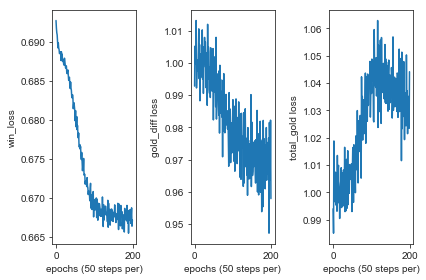

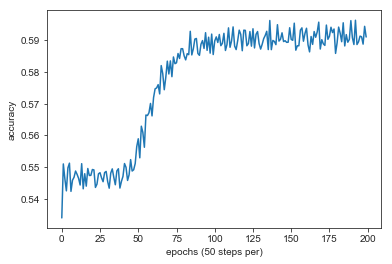

In [36]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
history = train_linear_model_triple(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=3,
            batch_size=500,
            epochs=200, 
            aux_weight=0.1,
            training_path=training_file_triple_novocab, 
            validation_path=validation_file_triple_novocab,
            compression_type='GZIP')

Train for 50 steps, validate for 50 steps
Epoch 1/500
50/50 - 7s - loss: 1.1897 - gold_diff_loss: 0.9975 - total_gold_loss: 1.0002 - radiant_win_loss: 0.6930 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5135 - val_loss: 1.1894 - val_gold_diff_loss: 0.9963 - val_total_gold_loss: 1.0007 - val_radiant_win_loss: 0.6928 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5225
Epoch 2/500
50/50 - 4s - loss: 1.1875 - gold_diff_loss: 0.9938 - total_gold_loss: 0.9880 - radiant_win_loss: 0.6925 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5303 - val_loss: 1.1890 - val_gold_diff_loss: 0.9976 - val_total_gold_loss: 1.0004 - val_radiant_win_loss: 0.6924 - val_gold_diff_accuracy: 0.0000e+00 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5371
Epoch 3/500
50/50 - 5s - loss: 1.1901 - gold_diff_loss: 1.0097 - total_gold_loss: 1.0028 - r

Epoch 20/500
50/50 - 4s - loss: 1.1849 - gold_diff_loss: 1.0017 - total_gold_loss: 1.0033 - radiant_win_loss: 0.6891 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5445 - val_loss: 1.1833 - val_gold_diff_loss: 1.0034 - val_total_gold_loss: 0.9895 - val_radiant_win_loss: 0.6888 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5469
Epoch 21/500
50/50 - 4s - loss: 1.1848 - gold_diff_loss: 1.0111 - total_gold_loss: 1.0020 - radiant_win_loss: 0.6884 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5503 - val_loss: 1.1835 - val_gold_diff_loss: 0.9971 - val_total_gold_loss: 0.9978 - val_radiant_win_loss: 0.6888 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5452
Epoch 22/500
50/50 - 4s - loss: 1.1836 - gold_diff_loss: 1.0029 - total_gold_loss: 0.9965 - radiant_win_loss: 0.6886 - gold_diff_acc

Epoch 39/500
50/50 - 4s - loss: 1.1827 - gold_diff_loss: 1.0003 - total_gold_loss: 1.0057 - radiant_win_loss: 0.6875 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5422 - val_loss: 1.1819 - val_gold_diff_loss: 0.9998 - val_total_gold_loss: 1.0016 - val_radiant_win_loss: 0.6872 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5440
Epoch 40/500
50/50 - 4s - loss: 1.1813 - gold_diff_loss: 1.0037 - total_gold_loss: 0.9988 - radiant_win_loss: 0.6867 - gold_diff_accuracy: 4.0000e-05 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5477 - val_loss: 1.1805 - val_gold_diff_loss: 0.9948 - val_total_gold_loss: 0.9959 - val_radiant_win_loss: 0.6870 - val_gold_diff_accuracy: 0.0000e+00 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5449
Epoch 41/500
50/50 - 4s - loss: 1.1819 - gold_diff_loss: 0.9999 - total_gold_loss: 1.0004 - radiant_win_loss: 0.6873 - gold_diff_acc

Epoch 58/500
50/50 - 4s - loss: 1.1766 - gold_diff_loss: 0.9902 - total_gold_loss: 0.9883 - radiant_win_loss: 0.6851 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5460 - val_loss: 1.1779 - val_gold_diff_loss: 0.9943 - val_total_gold_loss: 0.9949 - val_radiant_win_loss: 0.6853 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5447
Epoch 59/500
50/50 - 5s - loss: 1.1760 - gold_diff_loss: 0.9898 - total_gold_loss: 0.9935 - radiant_win_loss: 0.6844 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5513 - val_loss: 1.1775 - val_gold_diff_loss: 0.9868 - val_total_gold_loss: 1.0045 - val_radiant_win_loss: 0.6848 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5469
Epoch 60/500
50/50 - 5s - loss: 1.1782 - gold_diff_loss: 1.0032 - total_gold_loss: 0.9939 - radiant_win_loss: 0.6849 - gold_diff_acc

Epoch 77/500
50/50 - 5s - loss: 1.1760 - gold_diff_loss: 1.0109 - total_gold_loss: 0.9945 - radiant_win_loss: 0.6828 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5494 - val_loss: 1.1745 - val_gold_diff_loss: 0.9979 - val_total_gold_loss: 0.9880 - val_radiant_win_loss: 0.6831 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5483
Epoch 78/500
50/50 - 4s - loss: 1.1735 - gold_diff_loss: 0.9978 - total_gold_loss: 0.9883 - radiant_win_loss: 0.6824 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5522 - val_loss: 1.1754 - val_gold_diff_loss: 0.9989 - val_total_gold_loss: 0.9946 - val_radiant_win_loss: 0.6832 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5475
Epoch 79/500
50/50 - 5s - loss: 1.1742 - gold_diff_loss: 0.9901 - total_gold_loss: 0.9945 - radiant_win_loss: 0.6830 - gold_diff_acc

Epoch 96/500
50/50 - 4s - loss: 1.1747 - gold_diff_loss: 0.9991 - total_gold_loss: 1.0030 - radiant_win_loss: 0.6821 - gold_diff_accuracy: 4.0000e-05 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5513 - val_loss: 1.1720 - val_gold_diff_loss: 0.9920 - val_total_gold_loss: 0.9986 - val_radiant_win_loss: 0.6810 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5568
Epoch 97/500
50/50 - 4s - loss: 1.1719 - gold_diff_loss: 0.9996 - total_gold_loss: 0.9967 - radiant_win_loss: 0.6806 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5596 - val_loss: 1.1727 - val_gold_diff_loss: 0.9961 - val_total_gold_loss: 0.9963 - val_radiant_win_loss: 0.6814 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5542
Epoch 98/500
50/50 - 4s - loss: 1.1702 - gold_diff_loss: 0.9939 - total_gold_loss: 0.9796 - radiant_win_loss: 0.6810 - gold_diff_acc

Epoch 115/500
50/50 - 5s - loss: 1.1676 - gold_diff_loss: 0.9971 - total_gold_loss: 0.9844 - radiant_win_loss: 0.6786 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5708 - val_loss: 1.1696 - val_gold_diff_loss: 1.0091 - val_total_gold_loss: 0.9873 - val_radiant_win_loss: 0.6790 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5652
Epoch 116/500
50/50 - 5s - loss: 1.1705 - gold_diff_loss: 1.0046 - total_gold_loss: 1.0100 - radiant_win_loss: 0.6783 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5691 - val_loss: 1.1681 - val_gold_diff_loss: 0.9932 - val_total_gold_loss: 0.9900 - val_radiant_win_loss: 0.6788 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5659
Epoch 117/500
50/50 - 5s - loss: 1.1679 - gold_diff_loss: 1.0004 - total_gold_loss: 0.9958 - radiant_win_loss: 0.6778 - gold_diff_

Epoch 134/500
50/50 - 4s - loss: 1.1658 - gold_diff_loss: 1.0055 - total_gold_loss: 0.9895 - radiant_win_loss: 0.6764 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5779 - val_loss: 1.1655 - val_gold_diff_loss: 0.9964 - val_total_gold_loss: 0.9872 - val_radiant_win_loss: 0.6770 - val_gold_diff_accuracy: 0.0000e+00 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5730
Epoch 135/500
50/50 - 5s - loss: 1.1676 - gold_diff_loss: 1.0025 - total_gold_loss: 1.0048 - radiant_win_loss: 0.6768 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5739 - val_loss: 1.1657 - val_gold_diff_loss: 0.9960 - val_total_gold_loss: 0.9946 - val_radiant_win_loss: 0.6767 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5729
Epoch 136/500
50/50 - 5s - loss: 1.1649 - gold_diff_loss: 0.9918 - total_gold_loss: 0.9914 - radiant_win_loss: 0.6766 - gold_diff_

Epoch 153/500
50/50 - 4s - loss: 1.1628 - gold_diff_loss: 0.9940 - total_gold_loss: 1.0019 - radiant_win_loss: 0.6743 - gold_diff_accuracy: 4.0000e-05 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5823 - val_loss: 1.1638 - val_gold_diff_loss: 0.9961 - val_total_gold_loss: 0.9913 - val_radiant_win_loss: 0.6756 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5760
Epoch 154/500
50/50 - 5s - loss: 1.1658 - gold_diff_loss: 0.9982 - total_gold_loss: 0.9967 - radiant_win_loss: 0.6764 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5756 - val_loss: 1.1627 - val_gold_diff_loss: 1.0016 - val_total_gold_loss: 0.9926 - val_radiant_win_loss: 0.6743 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5790
Epoch 155/500
50/50 - 4s - loss: 1.1606 - gold_diff_loss: 0.9895 - total_gold_loss: 0.9947 - radiant_win_loss: 0.6735 - gold_diff_

Epoch 172/500
50/50 - 4s - loss: 1.1641 - gold_diff_loss: 0.9985 - total_gold_loss: 1.0066 - radiant_win_loss: 0.6745 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5833 - val_loss: 1.1608 - val_gold_diff_loss: 0.9939 - val_total_gold_loss: 0.9956 - val_radiant_win_loss: 0.6733 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5820
Epoch 173/500
50/50 - 4s - loss: 1.1627 - gold_diff_loss: 1.0064 - total_gold_loss: 1.0092 - radiant_win_loss: 0.6728 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5814 - val_loss: 1.1614 - val_gold_diff_loss: 1.0078 - val_total_gold_loss: 0.9940 - val_radiant_win_loss: 0.6728 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5826
Epoch 174/500
50/50 - 4s - loss: 1.1601 - gold_diff_loss: 1.0008 - total_gold_loss: 0.9954 - radiant_win_loss: 0.6723 - gold_diff_

Epoch 191/500
50/50 - 5s - loss: 1.1579 - gold_diff_loss: 0.9893 - total_gold_loss: 0.9963 - radiant_win_loss: 0.6715 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5878 - val_loss: 1.1597 - val_gold_diff_loss: 0.9998 - val_total_gold_loss: 0.9978 - val_radiant_win_loss: 0.6719 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5841
Epoch 192/500
50/50 - 4s - loss: 1.1623 - gold_diff_loss: 0.9981 - total_gold_loss: 1.0042 - radiant_win_loss: 0.6734 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5786 - val_loss: 1.1606 - val_gold_diff_loss: 1.0021 - val_total_gold_loss: 1.0001 - val_radiant_win_loss: 0.6723 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5844
Epoch 193/500
50/50 - 5s - loss: 1.1600 - gold_diff_loss: 1.0012 - total_gold_loss: 1.0001 - radiant_win_loss: 0.6719 - gold_diff_

Epoch 210/500
50/50 - 5s - loss: 1.1615 - gold_diff_loss: 1.0132 - total_gold_loss: 1.0081 - radiant_win_loss: 0.6716 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5844 - val_loss: 1.1601 - val_gold_diff_loss: 1.0008 - val_total_gold_loss: 1.0020 - val_radiant_win_loss: 0.6719 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5846
Epoch 211/500
50/50 - 5s - loss: 1.1546 - gold_diff_loss: 0.9816 - total_gold_loss: 0.9752 - radiant_win_loss: 0.6713 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5876 - val_loss: 1.1592 - val_gold_diff_loss: 0.9985 - val_total_gold_loss: 0.9999 - val_radiant_win_loss: 0.6715 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5850
Epoch 212/500
50/50 - 5s - loss: 1.1616 - gold_diff_loss: 1.0121 - total_gold_loss: 1.0138 - radiant_win_loss: 0.6713 - gold_diff_

Epoch 229/500
50/50 - 4s - loss: 1.1584 - gold_diff_loss: 0.9931 - total_gold_loss: 1.0092 - radiant_win_loss: 0.6707 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5852 - val_loss: 1.1593 - val_gold_diff_loss: 0.9982 - val_total_gold_loss: 1.0004 - val_radiant_win_loss: 0.6716 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5851
Epoch 230/500
50/50 - 4s - loss: 1.1586 - gold_diff_loss: 1.0042 - total_gold_loss: 1.0029 - radiant_win_loss: 0.6706 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5882 - val_loss: 1.1581 - val_gold_diff_loss: 0.9955 - val_total_gold_loss: 0.9962 - val_radiant_win_loss: 0.6713 - val_gold_diff_accuracy: 0.0000e+00 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5863
Epoch 231/500
50/50 - 5s - loss: 1.1586 - gold_diff_loss: 0.9956 - total_gold_loss: 1.0037 - radiant_win_loss: 0.6711 - gold_diff_

Epoch 248/500
50/50 - 4s - loss: 1.1600 - gold_diff_loss: 0.9943 - total_gold_loss: 1.0113 - radiant_win_loss: 0.6716 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5843 - val_loss: 1.1566 - val_gold_diff_loss: 0.9828 - val_total_gold_loss: 1.0004 - val_radiant_win_loss: 0.6708 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5867
Epoch 249/500
50/50 - 4s - loss: 1.1559 - gold_diff_loss: 0.9902 - total_gold_loss: 0.9954 - radiant_win_loss: 0.6701 - gold_diff_accuracy: 4.0000e-05 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5904 - val_loss: 1.1563 - val_gold_diff_loss: 0.9879 - val_total_gold_loss: 0.9984 - val_radiant_win_loss: 0.6704 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5874
Epoch 250/500
50/50 - 4s - loss: 1.1565 - gold_diff_loss: 0.9957 - total_gold_loss: 1.0107 - radiant_win_loss: 0.6691 - gold_diff_

Epoch 267/500
50/50 - 4s - loss: 1.1576 - gold_diff_loss: 0.9887 - total_gold_loss: 0.9976 - radiant_win_loss: 0.6713 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5870 - val_loss: 1.1582 - val_gold_diff_loss: 0.9873 - val_total_gold_loss: 1.0041 - val_radiant_win_loss: 0.6713 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5860
Epoch 268/500
50/50 - 4s - loss: 1.1552 - gold_diff_loss: 0.9898 - total_gold_loss: 0.9985 - radiant_win_loss: 0.6694 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5876 - val_loss: 1.1563 - val_gold_diff_loss: 0.9916 - val_total_gold_loss: 1.0002 - val_radiant_win_loss: 0.6700 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5880
Epoch 269/500
50/50 - 5s - loss: 1.1585 - gold_diff_loss: 1.0030 - total_gold_loss: 1.0006 - radiant_win_loss: 0.6707 - gold_diff_

Epoch 286/500
50/50 - 5s - loss: 1.1588 - gold_diff_loss: 0.9982 - total_gold_loss: 1.0050 - radiant_win_loss: 0.6709 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5852 - val_loss: 1.1559 - val_gold_diff_loss: 0.9853 - val_total_gold_loss: 0.9991 - val_radiant_win_loss: 0.6702 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5897
Epoch 287/500
50/50 - 4s - loss: 1.1552 - gold_diff_loss: 0.9916 - total_gold_loss: 1.0039 - radiant_win_loss: 0.6689 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5914 - val_loss: 1.1561 - val_gold_diff_loss: 0.9837 - val_total_gold_loss: 0.9912 - val_radiant_win_loss: 0.6710 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5870
Epoch 288/500
50/50 - 4s - loss: 1.1563 - gold_diff_loss: 0.9875 - total_gold_loss: 1.0148 - radiant_win_loss: 0.6693 - gold_diff_

Epoch 305/500
50/50 - 5s - loss: 1.1556 - gold_diff_loss: 0.9817 - total_gold_loss: 1.0116 - radiant_win_loss: 0.6694 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5897 - val_loss: 1.1550 - val_gold_diff_loss: 0.9873 - val_total_gold_loss: 0.9987 - val_radiant_win_loss: 0.6695 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5905
Epoch 306/500
50/50 - 5s - loss: 1.1529 - gold_diff_loss: 0.9883 - total_gold_loss: 0.9947 - radiant_win_loss: 0.6682 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5904 - val_loss: 1.1567 - val_gold_diff_loss: 0.9881 - val_total_gold_loss: 1.0037 - val_radiant_win_loss: 0.6703 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5894
Epoch 307/500
50/50 - 5s - loss: 1.1598 - gold_diff_loss: 0.9849 - total_gold_loss: 1.0176 - radiant_win_loss: 0.6717 - gold_diff_

Epoch 324/500
50/50 - 5s - loss: 1.1521 - gold_diff_loss: 0.9834 - total_gold_loss: 0.9933 - radiant_win_loss: 0.6681 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5890 - val_loss: 1.1565 - val_gold_diff_loss: 0.9908 - val_total_gold_loss: 1.0020 - val_radiant_win_loss: 0.6701 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5886
Epoch 325/500
50/50 - 5s - loss: 1.1534 - gold_diff_loss: 0.9781 - total_gold_loss: 0.9993 - radiant_win_loss: 0.6689 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5903 - val_loss: 1.1557 - val_gold_diff_loss: 0.9860 - val_total_gold_loss: 1.0007 - val_radiant_win_loss: 0.6699 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5882
Epoch 326/500
50/50 - 5s - loss: 1.1558 - gold_diff_loss: 0.9820 - total_gold_loss: 1.0103 - radiant_win_loss: 0.6696 - gold_diff_

Epoch 343/500
50/50 - 4s - loss: 1.1519 - gold_diff_loss: 0.9867 - total_gold_loss: 0.9942 - radiant_win_loss: 0.6677 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5918 - val_loss: 1.1542 - val_gold_diff_loss: 0.9694 - val_total_gold_loss: 1.0027 - val_radiant_win_loss: 0.6699 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5908
Epoch 344/500
50/50 - 4s - loss: 1.1522 - gold_diff_loss: 0.9745 - total_gold_loss: 0.9903 - radiant_win_loss: 0.6690 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5912 - val_loss: 1.1553 - val_gold_diff_loss: 0.9789 - val_total_gold_loss: 1.0047 - val_radiant_win_loss: 0.6698 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5873
Epoch 345/500
50/50 - 4s - loss: 1.1556 - gold_diff_loss: 0.9793 - total_gold_loss: 1.0184 - radiant_win_loss: 0.6690 - gold_diff_

Epoch 362/500
50/50 - 4s - loss: 1.1515 - gold_diff_loss: 0.9601 - total_gold_loss: 1.0057 - radiant_win_loss: 0.6685 - gold_diff_accuracy: 4.0000e-05 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5924 - val_loss: 1.1522 - val_gold_diff_loss: 0.9691 - val_total_gold_loss: 0.9910 - val_radiant_win_loss: 0.6693 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5881
Epoch 363/500
50/50 - 4s - loss: 1.1555 - gold_diff_loss: 0.9912 - total_gold_loss: 1.0068 - radiant_win_loss: 0.6690 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5871 - val_loss: 1.1543 - val_gold_diff_loss: 0.9708 - val_total_gold_loss: 1.0021 - val_radiant_win_loss: 0.6699 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5882
Epoch 364/500
50/50 - 5s - loss: 1.1526 - gold_diff_loss: 0.9625 - total_gold_loss: 0.9842 - radiant_win_loss: 0.6706 - gold_diff_

Epoch 381/500
50/50 - 5s - loss: 1.1514 - gold_diff_loss: 0.9681 - total_gold_loss: 0.9927 - radiant_win_loss: 0.6687 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5880 - val_loss: 1.1536 - val_gold_diff_loss: 0.9693 - val_total_gold_loss: 1.0068 - val_radiant_win_loss: 0.6692 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5886
Epoch 382/500
50/50 - 5s - loss: 1.1540 - gold_diff_loss: 0.9807 - total_gold_loss: 1.0117 - radiant_win_loss: 0.6684 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5900 - val_loss: 1.1550 - val_gold_diff_loss: 0.9748 - val_total_gold_loss: 1.0120 - val_radiant_win_loss: 0.6694 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5883
Epoch 383/500
50/50 - 5s - loss: 1.1532 - gold_diff_loss: 0.9729 - total_gold_loss: 0.9959 - radiant_win_loss: 0.6694 - gold_diff_

Epoch 400/500
50/50 - 5s - loss: 1.1532 - gold_diff_loss: 0.9721 - total_gold_loss: 0.9907 - radiant_win_loss: 0.6699 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5880 - val_loss: 1.1515 - val_gold_diff_loss: 0.9644 - val_total_gold_loss: 0.9898 - val_radiant_win_loss: 0.6693 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5892
Epoch 401/500
50/50 - 5s - loss: 1.1508 - gold_diff_loss: 0.9696 - total_gold_loss: 1.0107 - radiant_win_loss: 0.6669 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5952 - val_loss: 1.1532 - val_gold_diff_loss: 0.9657 - val_total_gold_loss: 0.9952 - val_radiant_win_loss: 0.6700 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5875
Epoch 402/500
50/50 - 5s - loss: 1.1511 - gold_diff_loss: 0.9620 - total_gold_loss: 0.9986 - radiant_win_loss: 0.6685 - gold_diff_

Epoch 419/500
50/50 - 4s - loss: 1.1513 - gold_diff_loss: 0.9706 - total_gold_loss: 1.0106 - radiant_win_loss: 0.6672 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5924 - val_loss: 1.1546 - val_gold_diff_loss: 0.9754 - val_total_gold_loss: 1.0096 - val_radiant_win_loss: 0.6693 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5873
Epoch 420/500
50/50 - 5s - loss: 1.1510 - gold_diff_loss: 0.9569 - total_gold_loss: 1.0062 - radiant_win_loss: 0.6683 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5906 - val_loss: 1.1532 - val_gold_diff_loss: 0.9628 - val_total_gold_loss: 1.0023 - val_radiant_win_loss: 0.6697 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5885
Epoch 421/500
50/50 - 4s - loss: 1.1492 - gold_diff_loss: 0.9664 - total_gold_loss: 0.9860 - radiant_win_loss: 0.6678 - gold_diff_

Epoch 438/500
50/50 - 4s - loss: 1.1539 - gold_diff_loss: 0.9784 - total_gold_loss: 1.0152 - radiant_win_loss: 0.6682 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5896 - val_loss: 1.1522 - val_gold_diff_loss: 0.9682 - val_total_gold_loss: 1.0029 - val_radiant_win_loss: 0.6686 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5902
Epoch 439/500
50/50 - 5s - loss: 1.1499 - gold_diff_loss: 0.9585 - total_gold_loss: 1.0085 - radiant_win_loss: 0.6672 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5919 - val_loss: 1.1544 - val_gold_diff_loss: 0.9707 - val_total_gold_loss: 1.0014 - val_radiant_win_loss: 0.6701 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5877
Epoch 440/500
50/50 - 4s - loss: 1.1509 - gold_diff_loss: 0.9691 - total_gold_loss: 0.9952 - radiant_win_loss: 0.6681 - gold_diff_

Epoch 457/500
50/50 - 4s - loss: 1.1483 - gold_diff_loss: 0.9550 - total_gold_loss: 0.9988 - radiant_win_loss: 0.6671 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5922 - val_loss: 1.1525 - val_gold_diff_loss: 0.9623 - val_total_gold_loss: 0.9983 - val_radiant_win_loss: 0.6695 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5905
Epoch 458/500
50/50 - 4s - loss: 1.1500 - gold_diff_loss: 0.9565 - total_gold_loss: 1.0060 - radiant_win_loss: 0.6676 - gold_diff_accuracy: 4.0000e-05 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5929 - val_loss: 1.1518 - val_gold_diff_loss: 0.9566 - val_total_gold_loss: 1.0092 - val_radiant_win_loss: 0.6687 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5910
Epoch 459/500
50/50 - 4s - loss: 1.1509 - gold_diff_loss: 0.9646 - total_gold_loss: 1.0072 - radiant_win_loss: 0.6676 - gold_diff_

Epoch 476/500
50/50 - 4s - loss: 1.1515 - gold_diff_loss: 0.9663 - total_gold_loss: 1.0143 - radiant_win_loss: 0.6674 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5917 - val_loss: 1.1505 - val_gold_diff_loss: 0.9590 - val_total_gold_loss: 0.9958 - val_radiant_win_loss: 0.6685 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5927
Epoch 477/500
50/50 - 4s - loss: 1.1465 - gold_diff_loss: 0.9537 - total_gold_loss: 0.9837 - radiant_win_loss: 0.6669 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5948 - val_loss: 1.1530 - val_gold_diff_loss: 0.9576 - val_total_gold_loss: 1.0029 - val_radiant_win_loss: 0.6698 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5900
Epoch 478/500
50/50 - 4s - loss: 1.1513 - gold_diff_loss: 0.9620 - total_gold_loss: 1.0015 - radiant_win_loss: 0.6684 - gold_diff_

Epoch 495/500
50/50 - 4s - loss: 1.1515 - gold_diff_loss: 0.9508 - total_gold_loss: 1.0168 - radiant_win_loss: 0.6683 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5904 - val_loss: 1.1525 - val_gold_diff_loss: 0.9541 - val_total_gold_loss: 1.0125 - val_radiant_win_loss: 0.6691 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5875
Epoch 496/500
50/50 - 4s - loss: 1.1493 - gold_diff_loss: 0.9775 - total_gold_loss: 0.9960 - radiant_win_loss: 0.6663 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5900 - val_loss: 1.1492 - val_gold_diff_loss: 0.9505 - val_total_gold_loss: 1.0005 - val_radiant_win_loss: 0.6679 - val_gold_diff_accuracy: 4.0000e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5918
Epoch 497/500
50/50 - 4s - loss: 1.1494 - gold_diff_loss: 0.9482 - total_gold_loss: 0.9954 - radiant_win_loss: 0.6686 - gold_diff_

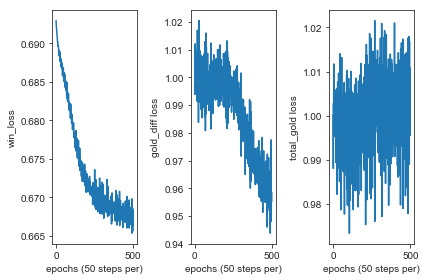

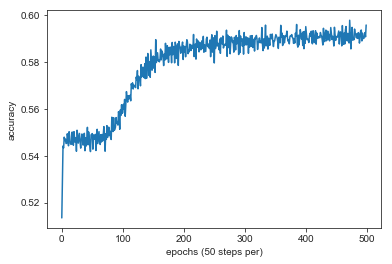

In [44]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
history = train_linear_model_triple(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=3,
            batch_size=500,
            epochs=500, 
            aux_weight=0.1,
            training_path=training_file_triple_novocab, 
            validation_path=validation_file_triple_novocab,
            compression_type='GZIP')

Train for 50 steps, validate for 50 steps
Epoch 1/50
50/50 - 18s - loss: 1.1862 - gold_diff_loss: 1.0010 - total_gold_loss: 0.9995 - radiant_win_loss: 0.6903 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5452 - val_loss: 1.1840 - val_gold_diff_loss: 1.0037 - val_total_gold_loss: 0.9998 - val_radiant_win_loss: 0.6886 - val_gold_diff_accuracy: 2.0104e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5459
Epoch 2/50
50/50 - 15s - loss: 1.1829 - gold_diff_loss: 1.0059 - total_gold_loss: 0.9978 - radiant_win_loss: 0.6878 - gold_diff_accuracy: 1.0000e-05 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5467 - val_loss: 1.1823 - val_gold_diff_loss: 1.0059 - val_total_gold_loss: 0.9984 - val_radiant_win_loss: 0.6873 - val_gold_diff_accuracy: 2.0104e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5458
Epoch 3/50
50/50 - 16s - loss: 1.1816 - gold_diff_loss: 1.0052 - total_gold_loss: 1.0026 - r

Epoch 20/50
50/50 - 14s - loss: 1.1622 - gold_diff_loss: 1.0732 - total_gold_loss: 0.9957 - radiant_win_loss: 0.6687 - gold_diff_accuracy: 1.0000e-05 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5914 - val_loss: 1.1631 - val_gold_diff_loss: 1.0711 - val_total_gold_loss: 0.9963 - val_radiant_win_loss: 0.6694 - val_gold_diff_accuracy: 2.0104e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5903
Epoch 21/50
50/50 - 14s - loss: 1.1624 - gold_diff_loss: 1.0714 - total_gold_loss: 0.9979 - radiant_win_loss: 0.6689 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5892 - val_loss: 1.1629 - val_gold_diff_loss: 1.0705 - val_total_gold_loss: 0.9971 - val_radiant_win_loss: 0.6693 - val_gold_diff_accuracy: 2.0104e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5901
Epoch 22/50
50/50 - 14s - loss: 1.1613 - gold_diff_loss: 1.0694 - total_gold_loss: 0.9920 - radiant_win_loss: 0.6686 - gold_diff_acc

Epoch 39/50
50/50 - 14s - loss: 1.1568 - gold_diff_loss: 1.0323 - total_gold_loss: 0.9910 - radiant_win_loss: 0.6682 - gold_diff_accuracy: 1.0082e-05 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5898 - val_loss: 1.1574 - val_gold_diff_loss: 1.0338 - val_total_gold_loss: 0.9907 - val_radiant_win_loss: 0.6684 - val_gold_diff_accuracy: 2.0104e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5906
Epoch 40/50
50/50 - 15s - loss: 1.1573 - gold_diff_loss: 1.0351 - total_gold_loss: 0.9937 - radiant_win_loss: 0.6681 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5905 - val_loss: 1.1583 - val_gold_diff_loss: 1.0341 - val_total_gold_loss: 0.9942 - val_radiant_win_loss: 0.6688 - val_gold_diff_accuracy: 2.0104e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5899
Epoch 41/50
50/50 - 15s - loss: 1.1567 - gold_diff_loss: 1.0303 - total_gold_loss: 0.9893 - radiant_win_loss: 0.6683 - gold_diff_acc

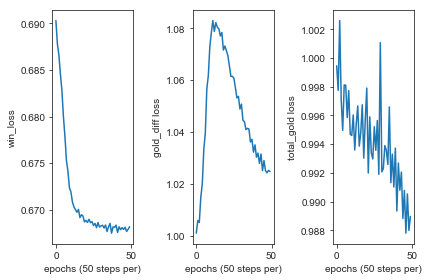

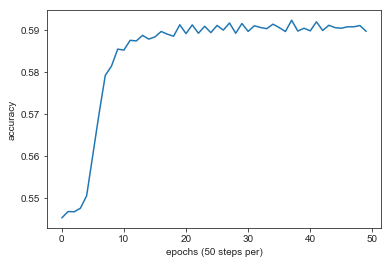

In [78]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
embedding, history = train_linear_model_triple(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=3,
            batch_size=2000,
            epochs=50, 
            aux_weight=0.1,
            training_path=training_file_triple_novocab, 
            validation_path=validation_file_triple_novocab,
            compression_type='GZIP')

Train for 50 steps, validate for 50 steps
Epoch 1/100
50/50 - 18s - loss: 1.1882 - gold_diff_loss: 1.0044 - total_gold_loss: 1.0007 - radiant_win_loss: 0.6914 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5420 - val_loss: 1.1871 - val_gold_diff_loss: 1.0084 - val_total_gold_loss: 1.0006 - val_radiant_win_loss: 0.6904 - val_gold_diff_accuracy: 2.0104e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5455
Epoch 2/100
50/50 - 16s - loss: 1.1858 - gold_diff_loss: 1.0058 - total_gold_loss: 0.9999 - radiant_win_loss: 0.6897 - gold_diff_accuracy: 1.0000e-05 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5472 - val_loss: 1.1857 - val_gold_diff_loss: 1.0051 - val_total_gold_loss: 1.0004 - val_radiant_win_loss: 0.6896 - val_gold_diff_accuracy: 2.0104e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5456
Epoch 3/100
50/50 - 16s - loss: 1.1852 - gold_diff_loss: 1.0058 - total_gold_loss: 1.0004 

Epoch 20/100
50/50 - 15s - loss: 1.1575 - gold_diff_loss: 0.9850 - total_gold_loss: 0.9629 - radiant_win_loss: 0.6739 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5797 - val_loss: 1.1593 - val_gold_diff_loss: 0.9890 - val_total_gold_loss: 0.9597 - val_radiant_win_loss: 0.6751 - val_gold_diff_accuracy: 2.0104e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5752
Epoch 21/100
50/50 - 15s - loss: 1.1557 - gold_diff_loss: 0.9851 - total_gold_loss: 0.9528 - radiant_win_loss: 0.6733 - gold_diff_accuracy: 1.0082e-05 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5798 - val_loss: 1.1583 - val_gold_diff_loss: 0.9890 - val_total_gold_loss: 0.9556 - val_radiant_win_loss: 0.6747 - val_gold_diff_accuracy: 2.0104e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5761
Epoch 22/100
50/50 - 15s - loss: 1.1544 - gold_diff_loss: 0.9844 - total_gold_loss: 0.9518 - radiant_win_loss: 0.6726 - gold_diff_

Epoch 39/100
50/50 - 17s - loss: 1.1444 - gold_diff_loss: 0.9765 - total_gold_loss: 0.9269 - radiant_win_loss: 0.6679 - gold_diff_accuracy: 1.0082e-05 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5909 - val_loss: 1.1458 - val_gold_diff_loss: 0.9774 - val_total_gold_loss: 0.9301 - val_radiant_win_loss: 0.6686 - val_gold_diff_accuracy: 2.0104e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5903
Epoch 40/100
50/50 - 17s - loss: 1.1436 - gold_diff_loss: 0.9727 - total_gold_loss: 0.9289 - radiant_win_loss: 0.6674 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5901 - val_loss: 1.1452 - val_gold_diff_loss: 0.9754 - val_total_gold_loss: 0.9289 - val_radiant_win_loss: 0.6684 - val_gold_diff_accuracy: 2.0104e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5905
Epoch 41/100
50/50 - 23s - loss: 1.1434 - gold_diff_loss: 0.9734 - total_gold_loss: 0.9263 - radiant_win_loss: 0.6674 - gold_diff_

Epoch 58/100
50/50 - 15s - loss: 1.1425 - gold_diff_loss: 0.9688 - total_gold_loss: 0.9248 - radiant_win_loss: 0.6672 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5907 - val_loss: 1.1437 - val_gold_diff_loss: 0.9683 - val_total_gold_loss: 0.9262 - val_radiant_win_loss: 0.6679 - val_gold_diff_accuracy: 2.0104e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5915
Epoch 59/100
50/50 - 15s - loss: 1.1424 - gold_diff_loss: 0.9660 - total_gold_loss: 0.9236 - radiant_win_loss: 0.6674 - gold_diff_accuracy: 1.0082e-05 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5917 - val_loss: 1.1434 - val_gold_diff_loss: 0.9663 - val_total_gold_loss: 0.9247 - val_radiant_win_loss: 0.6680 - val_gold_diff_accuracy: 2.0104e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5913
Epoch 60/100
50/50 - 15s - loss: 1.1423 - gold_diff_loss: 0.9661 - total_gold_loss: 0.9258 - radiant_win_loss: 0.6672 - gold_diff_

Epoch 77/100
50/50 - 14s - loss: 1.1420 - gold_diff_loss: 0.9554 - total_gold_loss: 0.9255 - radiant_win_loss: 0.6677 - gold_diff_accuracy: 1.0082e-05 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5915 - val_loss: 1.1431 - val_gold_diff_loss: 0.9605 - val_total_gold_loss: 0.9245 - val_radiant_win_loss: 0.6682 - val_gold_diff_accuracy: 2.0104e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5910
Epoch 78/100
50/50 - 14s - loss: 1.1412 - gold_diff_loss: 0.9598 - total_gold_loss: 0.9251 - radiant_win_loss: 0.6669 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5912 - val_loss: 1.1427 - val_gold_diff_loss: 0.9602 - val_total_gold_loss: 0.9253 - val_radiant_win_loss: 0.6679 - val_gold_diff_accuracy: 2.0104e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5913
Epoch 79/100
50/50 - 14s - loss: 1.1406 - gold_diff_loss: 0.9530 - total_gold_loss: 0.9225 - radiant_win_loss: 0.6671 - gold_diff_

Epoch 96/100
50/50 - 15s - loss: 1.1411 - gold_diff_loss: 0.9539 - total_gold_loss: 0.9225 - radiant_win_loss: 0.6675 - gold_diff_accuracy: 0.0000e+00 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5901 - val_loss: 1.1422 - val_gold_diff_loss: 0.9549 - val_total_gold_loss: 0.9259 - val_radiant_win_loss: 0.6679 - val_gold_diff_accuracy: 2.0104e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5912
Epoch 97/100
50/50 - 15s - loss: 1.1404 - gold_diff_loss: 0.9497 - total_gold_loss: 0.9255 - radiant_win_loss: 0.6670 - gold_diff_accuracy: 1.0082e-05 - total_gold_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5928 - val_loss: 1.1418 - val_gold_diff_loss: 0.9530 - val_total_gold_loss: 0.9253 - val_radiant_win_loss: 0.6678 - val_gold_diff_accuracy: 2.0104e-05 - val_total_gold_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5914
Epoch 98/100
50/50 - 15s - loss: 1.1413 - gold_diff_loss: 0.9531 - total_gold_loss: 0.9228 - radiant_win_loss: 0.6676 - gold_diff_

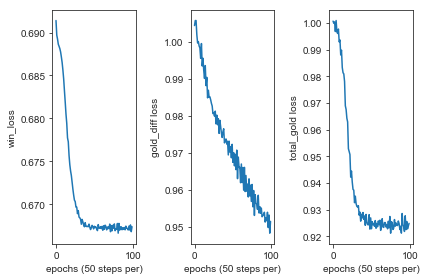

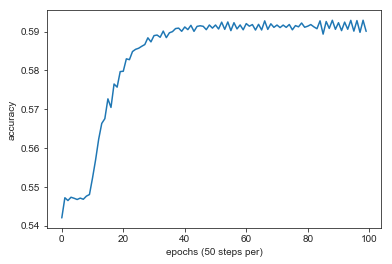

In [86]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
embedding, history = train_linear_model_triple(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=3,
            batch_size=2000,
            epochs=100, 
            aux_weight=0.1,
            training_path=training_file_triple_novocab, 
            validation_path=validation_file_triple_novocab,
            compression_type='GZIP')

### train radiant_win model with feature columns

In [97]:
training_file = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_training_data',
                             'radiant_windota2_training_data.tfrecords')
validation_file = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_validation_data',
                             'radiant_windota2_validation_data.tfrecords')
categorical_columns = [tf.feature_column.categorical_column_with_vocabulary_list(
                                                'radiant_heroes',
                                                hero_vocab),
                               tf.feature_column.categorical_column_with_vocabulary_list(
                                                'dire_heroes',
                                                hero_vocab)]
indicator_columns = [tf.feature_column.indicator_column(
                                        categorical_columns[0]),
                            tf.feature_column.indicator_column(
                                        categorical_columns[1])]
embedding_dim = 3
embedding_columns = [tf.feature_column.embedding_column(
                                categorical_columns[0],
                                embedding_dim),
                    tf.feature_column.embedding_column(
                                categorical_columns[1],
                                embedding_dim)]

In [98]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
history = train_model(optimizer,
            indicator_columns,
            batch_size=500, 
            epochs=5, 
            training_path=training_file, 
            validation_path=validation_file,
            compression_type='GZIP')

NameError: name 'vocab_len' is not defined

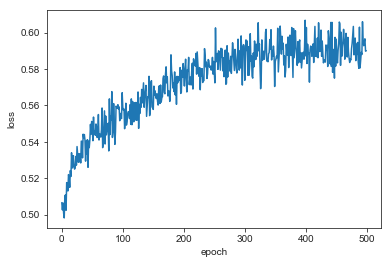

In [82]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
history = train_model(optimizer,
            embedding_columns,
            batch_size=500, 
            epochs=500, 
            training_path=training_file, 
            validation_path=validation_file,
            compression_type='GZIP')

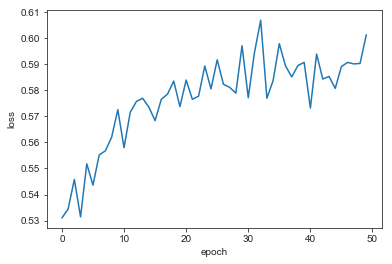

In [85]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
history = train_model(optimizer,
            embedding_columns,
            batch_size=500, 
            epochs=50, 
            training_path=training_file, 
            validation_path=validation_file,
            compression_type='GZIP')

In [51]:
%load_ext tensorboard

In [52]:
log = os.path.join('..','..','..','tmp_log_dir')
%tensorboard --logdir '../../../tmp_log_dir' --reload_multifile=true

Reusing TensorBoard on port 6014 (pid 9324), started 21:09:55 ago. (Use '!kill 9324' to kill it.)

### Investigate embeding layer

In [141]:
logdir = os.path.join('..','..','..','tmp_log_dir','20191029-164616','embedding.npy')
np.save(logdir,embedding)

In [118]:
pca = decomposition.PCA(n_components=2)
pca_embedding = pca.fit_transform(embedding)

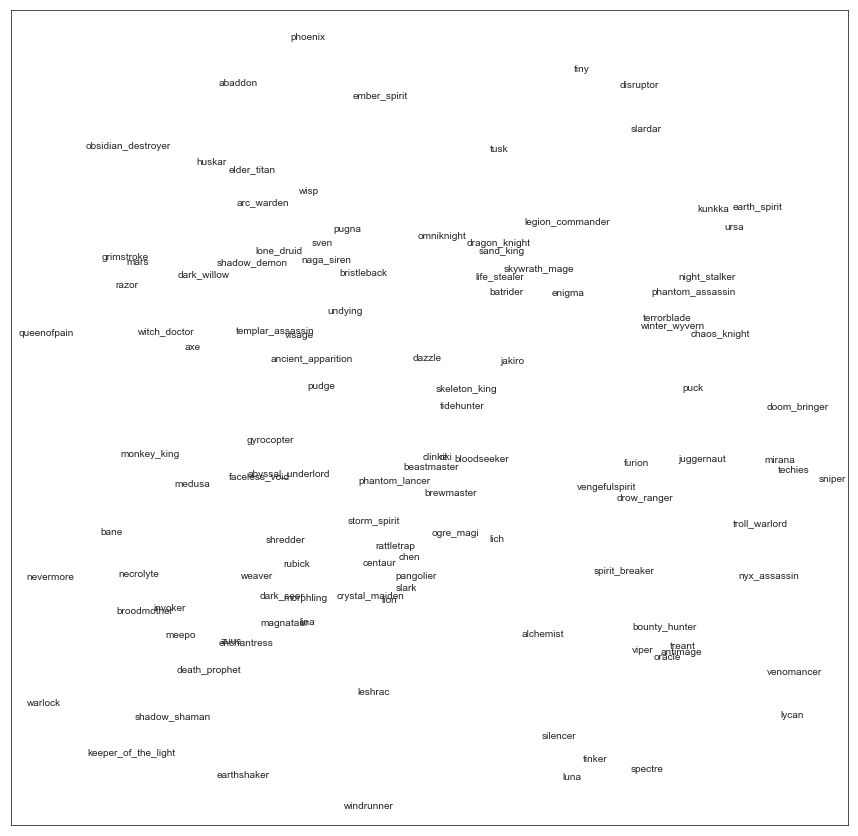

In [130]:
for vec,hero in zip(pca_embedding,hero_list['result']['heroes']):
    plt.text(vec[0],vec[1],hero['name'][14:])
    
plot_range = max(embedding[:,0])
plt.xlim(-plot_range*1.15,plot_range*1.3)
plt.ylim(-plot_range*1.15,plot_range*1.3)
plt.xticks([])
plt.yticks([])
plt.show()

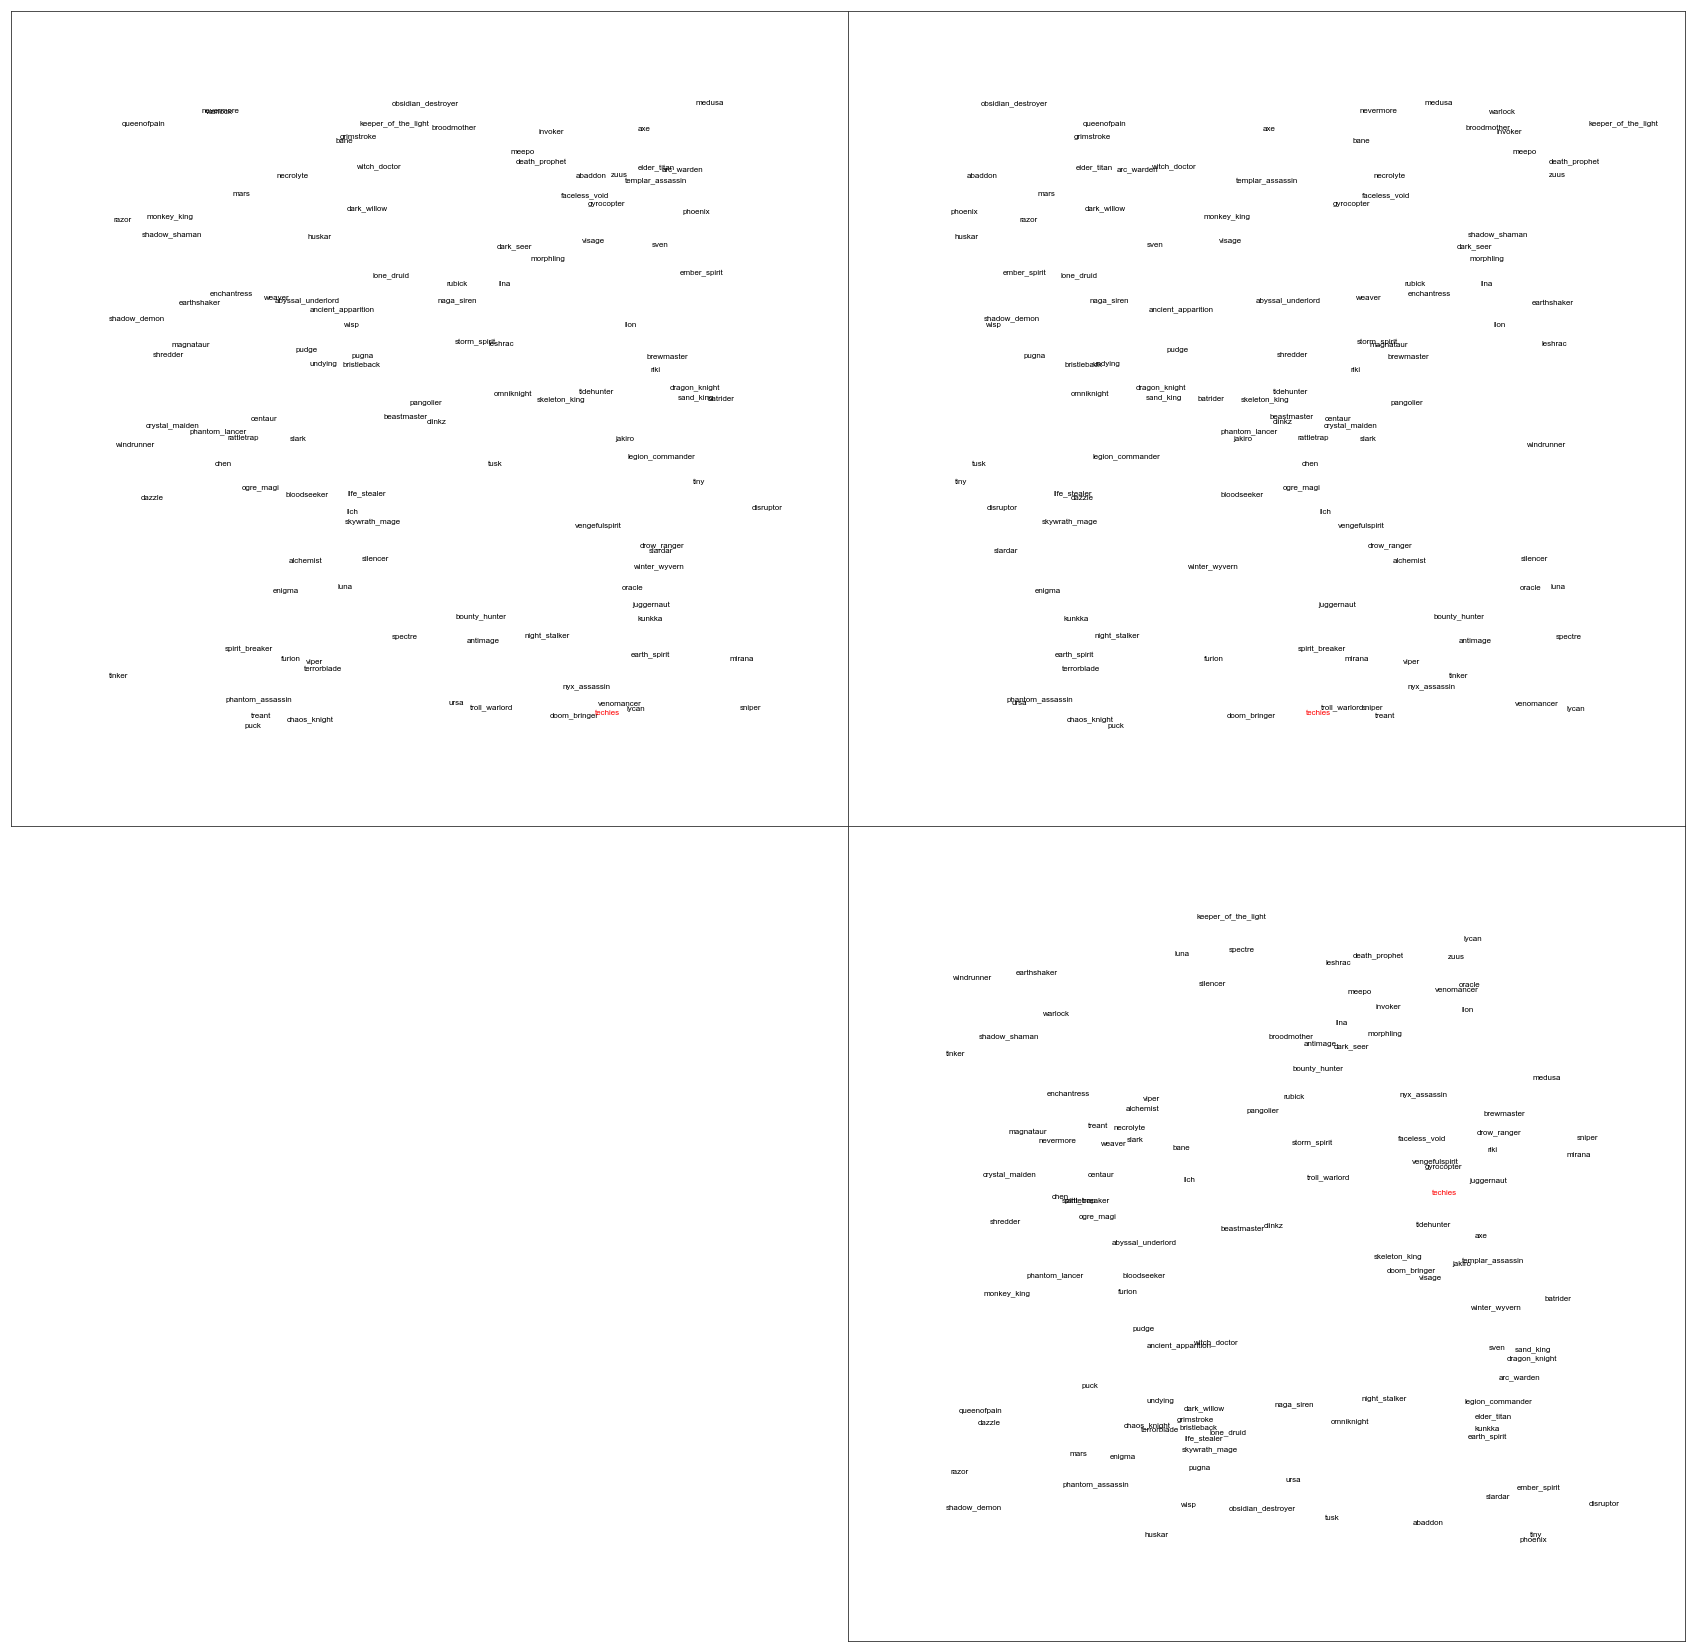

In [123]:
fig, ax = plt.subplots(2,2,figsize=(30,30))

plot_range = 1.3*max(embedding[:,0])

for vec,hero in zip(embedding,hero_list['result']['heroes']):
    if hero['name'][14:]=='techies':
        font_dict = {'color': 'red',
                     'size': 8}
    else:
        font_dict = {'color': 'black',
                     'size': 8}

    ax[0,0].text(vec[1],vec[0],hero['name'][14:],fontdict=font_dict)
    ax[0,1].text(vec[2],vec[0],hero['name'][14:],fontdict=font_dict)
    ax[1,1].text(vec[1],vec[2],hero['name'][14:],fontdict=font_dict)
    ax[1,0].axis('off')
# Do a little setup to make sure the plot displays nicely.
for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_xlim([-plot_range,plot_range])
        ax[i,j].set_ylim([-plot_range,plot_range])
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        
plt.subplots_adjust(wspace=0, hspace=0)
plt.show() 